# Imports

In [140]:
import numpy as np
import time
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from iminuit.cost import LeastSquares
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import binned_statistic 

# import fitsio

%matplotlib inline

In [141]:
# target_redshift = 2.8
target_redshift = 2.8

# safe_z = str(target_redshift).replace('.', '-')

# path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_full_output.txt'
# data = np.loadtxt(path)
# full_v = data[:, 0]
# full_xiG = data[:, 1]
# full_v_spacing = full_v[1] - full_v[0]
# N = len(full_xiG)
# L = N * full_v_spacing

# # FFT to power
# fft_xiG = np.fft.rfft(full_xiG)
# power = full_v_spacing * fft_xiG

# # Compute corresponding k values
# karr = 2 * np.pi * np.fft.rfftfreq(N, d=full_v_spacing)

# # Take only the real part of the power spectrum
# # power_real = power.real  # Or use np.abs(power) if you're interested in magnitude
# power_real = np.abs(power)
# power_real2 = power.real

# plt.loglog(karr, power_real, label='abs(val)', alpha=0.7)
# plt.loglog(karr, power_real2, label='.real', alpha=0.7)
# plt.legend()
# plt.ylim(10e-6)
# plt.show()


# path3 = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
# path2 = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/test_P_G-{safe_z}.txt'
# data2 = np.loadtxt(path2)
# data3 = np.loadtxt(path3)
# k_array = data2[:, 0]
# p1d_array = data2[:, 1]
# k_array3 = data3[:, 0]
# p1d_array3 = data3[:, 1]

# plt.loglog(k_array, p1d_array, label='file, new', alpha=0.5)
# plt.loglog(k_array3, p1d_array3, label='file, old', alpha=0.5)
# # plt.loglog(karr, power_real, label='new test', alpha=0.5)
# plt.legend()
# plt.show()

In [142]:
# cf_fullpath = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_full_output.txt'
# data_full = np.loadtxt(cf_fullpath)
# full_v = data_full[:, 0]
# full_xiG = data_full[:, 1]

# cf_fullpath_old = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/{safe_z}_xiG_full_output.txt'
# data_full_old = np.loadtxt(cf_fullpath_old)
# full_v_old = data_full_old[:, 0]
# full_xiG_old = data_full_old[:, 1]

# plt.plot(full_v, full_xiG, label='new')
# plt.plot(full_v_old, full_xiG_old, label='old')
# plt.legend(loc='upper center')

# Mean flux

Mean Flux from Turner et al. (2024): https://arxiv.org/html/2405.06743v2

$$ \tau(z) = \tau_0 (1+z)^{\gamma} $$

where, 

$ \tau_0 = 0.00246 \pm 0.14 $ and $ \gamma = 3.62 \pm 0.04 $,

and mean flux is, $\bar{F}(z) = e^{-\tau(z)}$

In [143]:
# Mean flux from Turner et al. (2024)

def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

DESI EDR parameters, PD13 pivot points (k,z), and fiducial / target P1D are defined at: 
https://github.com/p-slash/qsotools/blob/c58549f41fb2bd56a59c4b4362d8b331334ce13a/py/qsotools/fiducial.py#L42

And PD 13 reffers to: https://arxiv.org/abs/1306.5896

In [144]:
# DESI EDR Parameters

DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

# set pivot points for k and z using fiducial power estimate
PD13_PIVOT_K = 0.009 # note: k_0
PD13_PIVOT_Z = 3.0   # note: z0 = 3

Naim_2020_parameters = (
    0.066, -2.685, -0.22,
    3.59, -0.18, 0.53)

#######################################
# DESI_EDR_PARAMETERS = ( # Y1 paper 2025
#     0.0763, -2.52, -0.128,
#     3.67, -0.286, 0.0369)

# DESI_EDR_PARAMETERS = ( # naim edr paper 2023
#     0.066, -2.685, -0.22,
#     3.59, -0.16, 0.053)


    

Baseline power spectrum estimate modifies fitting function from PD13 (eq. 14), with best fitting parameters (A, n, $\alpha$, B, $\beta$, $k_1$(km/s)), with a Lorentzian decay: 

$$ \frac{k P(k,z)}{\pi} = A \frac{(k/k_0)^{3 + n + \alpha \ln k/k_0}}{1 + (k / k_1)^2} \left(\frac{1+z}{1+z_0}\right)^{B + \beta \ln k/k_0} $$

where $k_0 = 0.009$ km/s and $z_0 = 3.0$. 

**Table 1.** Top:PD13 BOSS likelihood fitting parameters. Bottom: Karacaylı et al. 2020 (eq. 17), DESI Lite, not EDR

| A  | n | $\alpha$ | B | $\beta$ | $k_1$(km/s) |
| ---|---|  ---     |---|---      |---          |
| 0.06 |-2.55|  -.010     |3.55|-0.28      | -  |
| 0.066|-2.685|  -0.22     |3.59|-0.18      |0.53|

In [145]:
# Define target P1D
# note: lmd = k1, PD13_PIVOT_K = k0, PD13_PIVOT_Z = z0

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10

    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)

    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)

    return result


# Define Lognormal Transforms and Functions

Redshift evolution: 

$$a^2(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu} $$

where, $z_0 = 3$, and $\nu = 2.82$, such that: 

$$a(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu / 2} $$


In [146]:
def a2_z(zp, nu=2.82, z0=3.0):
    return np.power((1. + zp) / (1.+z0), -nu)

def a_z(zp, nu=2.82, z0=3.0):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))

Optical Depth: 

$$ \tau(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} $$

where, $z_0 = 3$, $\tau_0 = 0.55$, and $\tau_1 = 5.1$

In [147]:
def t_of_z(zp, tau0=0.55, tau1=5.1, z0=3.):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

Lognormal Transform: 

$$ n(z) = e^{2 \delta(z) - \sigma^2} $$

In [148]:
def n_z(zp, nu, sigma2, z0=3):
    return np.exp(-a2_z(zp, nu, z0) - sigma2)

Apply to optical depth: 

$$ x(z) \rightarrow \tau(z) * n(z) $$


$$ x(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * e^{2 \delta(z) - \sigma^2} $$

In [149]:
def x_of_z(zp, tau0, tau1, nu, sigma2, z0=3):
    return t_of_z(zp, tau0, tau1, z0) * np.exp(-a2_z(zp, nu, z0) * sigma2)

Flux: 

$$ F(z) = e^{-\tau(z)}  $$

$$ F(z) \rightarrow e^{ -\tau(z) * n(z) } \rightarrow e^{-x(z)}$$

such that:

$$ F(z) = exp\left[- \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * e^{2 \left( \frac{1+z}{1+z_0} \right)^{-\nu / 2} \delta(v)} * e^{- \left( \frac{1+z}{1+z_0} \right)^{-\nu} \sigma^2}\right] $$

where, $\delta(v) \approx \sqrt{2 \sigma^2} * \delta_g$, to simulate FT on gaussian grid. 

In [150]:
# note: for mock generation code, need to use \delta (v), not \delta (g)
# the sqrt{2 sigma^2} is to simulate the FFT on gaussian grid

def Flux_d_z(delta_g, z, tau0, tau1, nu, sigma2, z0=3):
    e1 = np.exp(2 * a2_z(z, nu / 2, z0) * np.sqrt(2 * sigma2) * delta_g)
    e2 = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    return np.exp(-e2 * e1)

Mean Flux, using Gaussian-Hermite Quadrature:

In [151]:
# def Gauss-Hermite quadrature points and weights
degree = 25

gausshermite_xi_deg, gausshermite_wi_deg = np.polynomial.hermite.hermgauss(degree)

def lognMeanFluxGH(z, tau0, tau1, nu, sigma2, degree = degree, z0=3):
    gausshermite_xi, gausshermite_wi = np.polynomial.hermite.hermgauss(degree)

    XIXI, ZZ = np.meshgrid(gausshermite_xi, z)

    Y = Flux_d_z(XIXI, ZZ, tau0, tau1, nu, sigma2, z0)
    result = np.dot(Y, gausshermite_wi)

    return result / np.sqrt(np.pi)
    

Input Gaussian Power: 

$$ P(k) = \frac{\exp [ n * q_0 - \alpha q_0^2 ]}{1 + (k/k_1)^{\gamma}} * \exp \left[ -\frac{(k/0.2)^2}{2} \right] $$

where, $q_0 = \ln \left(\frac{k}{0.001}+10^{-15}\right)$, $n = 0.5$, $\gamma = 1.8$, $k_1 = 0.04$

In [152]:
def lognGeneratingPower(k, n=0.5, alpha=0.26, gamma=1.8, k1=0.04):
    q0 = np.log(k / 0.001 + 1e-15)
    return np.exp(n * q0 - alpha * q0**2) / (1. + (k / k1)**gamma) * np.exp(-(k / 0.2)**2 / 2)

In [153]:
# Calculate meshgrid for Gauss-Hermite once
YY1, YY2 = np.meshgrid(gausshermite_xi_deg, gausshermite_xi_deg, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg, gausshermite_wi_deg, indexing='ij')

#####################################################

# lognormal xi_f from xi_g
# goes point by point, not dealing with arrays

# def lognXiFfromXiG_pointwise(z, xi_gauss, sigma2= 1.50381, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    # """
    # Arguments
    # ---------
    # z: float
    #     Single redshift
    # tau0, tau1: float
    #     Amplitude (tau0) and power (tau1) of optical depth
    # nu: float
    #     Slope of growth (a(z) -> D(z))
    # xi_gauss: float
    #     Single xi_g value from Gaussian random field
    # """
    # # sigma2 = xi_gauss[0]
    # # sigma2 = 1.50381
    # xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    # xi_cosine = np.sqrt(1 - xi_sine**2)
    # XI_VEC = np.array([xi_sine, xi_cosine])

    # YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # # Redshift-dependent computations
    # mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    # sigmaz = a2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    # tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    # delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    # delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    # F1 = np.exp(-tempxz * np.exp(delta1))
    # F2 = np.exp(-tempxz * np.exp(delta2))
    # D1 = F1 / mean_flux_z - 1
    # D2 = F2 / mean_flux_z - 1
    # tempfunc = WW1 * WW2 * D1 * D2

    # # Return a single xi_f scalar
    # xi_f = np.sum(tempfunc) / np.pi

    # return xi_f

# check that lognXiFfromXiG returns a single xi_f value for a SINGLE xi_g value
# lognXiFfromXiG_pointwise(z=2.8, xi_gauss=0.2) # CHECK!
    

# Fit for mean flux

In [154]:
# create redshift array
z_array = np.linspace(1.8, 5.0, 500)

# choose precision
precision = 1e-5

# def model and error / precision
F_turner = turner24_mf(z_array)
Err_turner = F_turner * precision + 1e-8

Define a cost funciton: 

$$ d = \frac{\bar{F}_{model}-\bar{F}_{measured}}{Error_{model}} $$

and, $cost = d \cdot d$ 

In [155]:
# def cost function for 4 parameters
def cost(tau0, tau1, nu, sigma2):
    d = (F_turner - lognMeanFluxGH(z_array, tau0, tau1, nu, sigma2, z0=3)) / Err_turner
    return d.dot(d)


# def cost2(tau0, tau1, nu):
#     # d = (F_turner - Flux_d_z(gaussian_random_field, z_array, tau0, tau1, nu, sigma2=1.6, z0=3).mean()) / Err_turner
#     d = (F_turner - lognMeanFluxGH(z_array, tau0, tau1, nu, sigma2=1.0, z0=3)) / Err_turner
#     return d.dot(d)


# Set initial guesses for fitting parameters
tau0, tau1, nu, sigma2 = 0.55, 5.1, 2.82, 1.0
# tau0, tau1, nu = 0.55, 5.1, 2.82

# minimizer: minimizes cost and determines best fit values for parameters
mini = Minuit(cost, tau0, tau1, nu, sigma2)
# mini = Minuit(cost2, tau0, tau1, nu)

# try setting bounds on sigma2
# mini.limits['sigma2'] = (1.0, 3.0)  # Set bounds on sigma2
# optional: fix sigma2
# mini.fixed['sigma2'] = True

mini.errordef = Minuit.LEAST_SQUARES
mini.migrad()



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.659e+05                  │              Nfcn = 376              │
│ EDM = 2.08e-08 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau0   │ 673.77e-3 │  0.06e-3  │            │            │         │         │       │
│ 1 │ tau1   │  5.31008  │  0.00016  │            │            │         │         │       │
│ 2 │ nu     │  2.16175  │  0.00017  │            │            │         │         │       │
│ 3 │ sigma2 │  1.50381  │  0.00014  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │      tau0      tau1        nu    sigma2 │
├────────┼─────────────────────────────────────────┤
│   tau0 │  3.64e-09     -6e-9      8e-9      9e-9 │
│   tau1 │     -6e-9  2.61e-08 -0.027e-6 -0.015e-6 │
│     nu │      8e-9 -0.027e-6  2.91e-08  0.019e-6 │
│ sigma2 │      9e-9 -0.015e-6  0.019e-6  2.01e-08 │
└────────┴─────────────────────────────────────────┘

In [156]:
# # Open a file for writing the data
# with open('flux_data.txt', 'w') as f:
#     # Loop through each value in z_array and F_turner
#     for z, flux in zip(z_array, F_turner):
#         # Write the z and flux values in two columns
#         # f.write(f"{z}  {flux+(0.5**z)}\n")
#         f.write(f"{z}  {flux}\n")

# print("Data exported successfully!")

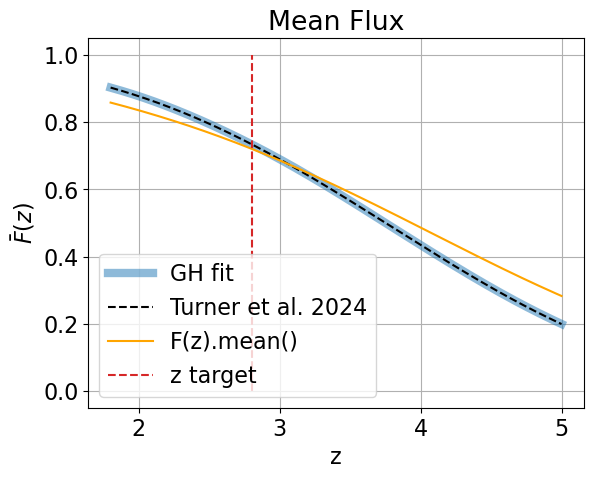

In [157]:
z_list = 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0
gaussian_random_field = np.random.default_rng(10).normal(size=500)

def basic_flux_mean(z):
    mean_flux = np.average(Flux_d_z(gaussian_random_field, z, *mini.values, z0=3))
    return(mean_flux)
    
flux_test = []
turner24_list = []
percent_diff_flux_model = []

for i in z_array:
    flux_test.append(basic_flux_mean(i))
    turner24_list.append(turner24_mf(i))
    percent_diff_flux_model.append(100* ((basic_flux_mean(i) - turner24_mf(i)) / turner24_mf(i)))


plt.plot(z_array, lognMeanFluxGH(z_array, *mini.values), color='tab:blue', ls='-', label='GH fit', lw='6', alpha = 0.5)
plt.plot(z_array, F_turner, color='black', ls='--', label='Turner et al. 2024')
plt.plot(z_array, flux_test, color='orange', label='F(z).mean()')
plt.vlines(target_redshift, ymin=0,ymax=1, ls='--', color='tab:red', label='z target')

plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.legend()
plt.grid(True)
plt.show()


# percent_diff_flux = 100 * ((flux_test) - (lognMeanFluxGH(z_array, *mini.values)) / (flux_test))
# plt.plot(z_array, np.abs(percent_diff_flux), color='tab:blue', ls='-', lw='2')
# plt.title('% diff GH and .mean()')
# plt.xlabel('z')
# plt.ylabel("percent diff")
# plt.legend()
# plt.grid(True)
# plt.show()


# plt.plot(z_array, np.abs(percent_diff_flux_model), color='tab:blue', ls='-', lw='2')
# plt.title('% diff .mean() and turner24')
# plt.xlabel('z')
# plt.ylabel("percent diff")
# # plt.legend()
# plt.grid(True)
# plt.show()

# Fit for Correlation Function

In [158]:
# def lognXiFfromXiG_pointwise(z, xi_gauss, sigma2= 1.50381, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
def lognXiFfromXiG_pointwise(z, xi_gauss, tau0, tau1, nu, sigma2, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: float
        Single xi_g value from Gaussian random field
    """
    # sigma2 = xi_gauss[0]
    # sigma2 = 1.50381
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine])

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = a2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return a single xi_f scalar
    xi_f = np.sum(tempfunc) / np.pi

    return xi_f

# test
lognXiFfromXiG_pointwise(2.8, 0.8, *mini.values, z0=3)

0.08639596951505282

In [159]:
mini.values

<ValueView tau0=0.6737651580016017 tau1=5.310084075374157 nu=2.161750475695124 sigma2=1.5038053361999801>

In [160]:
# qsotools_param = (
#     7.63089e-02, -2.52054e+00, -1.27968e-01,
#     3.67469e+00, 2.85951e-01, 7.33473e+02)

# Y1_2025_param = ( 
#     0.0763, -2.52, -0.128,
#     3.67, -0.286, 0.0369)

# EDR_2023_param = ( 
#     0.066, -2.685, -0.22,
#     3.59, -0.16, 0.053)

# test_param = (
#     0.0763, -2.52, -0.128,
#     3.67, -0.286, 7.33473e+01)


# qsotools_fit = np.empty((zlist.size, k_arr.size))
# Y1_2025_fit = np.empty((zlist.size, k_arr.size))
# EDR_2023_fit = np.empty((zlist.size, k_arr.size))
# test_fit = np.empty((zlist.size, k_arr.size))


# # Evaluate P1D for each (k,z), using DESI EDR Param. def. above
# # for i, z in enumerate(zlist):
# #     qsotools_fit[i] = evaluatePD13Lorentz((k_arr, z), *qsotools_param)
# #     Y1_2025_fit[i] = evaluatePD13Lorentz((k_arr, z), *Y1_2025_param)
# #     EDR_2023_fit[i] = evaluatePD13Lorentz((k_arr, z), *EDR_2023_param)
# #     test_fit[i] =  evaluatePD13Lorentz((k_arr, z), *test_param)

# # plt.loglog(k_arr[1:], qsotools_fit[4][1:], label = 'qsotools fit vals')
# # plt.loglog(k_arr[1:], Y1_2025_fit[4][1:],  label = 'Y1 2025  fit vals')
# # plt.loglog(k_arr[1:], EDR_2023_fit[4][1:], label = 'EDR 2023 fit vals')
# # plt.loglog(k_arr[1:], test_fit[4][1:], label = 'test 2023 fit vals')

# # plt.xlabel('k (s/km)')
# # plt.ylabel(rf'$P_{{1D}}$ (z = {target_redshift})')
# # plt.legend()
# # plt.show()

In [161]:
# create velocity array 
numvpoints = 2**20
dv = 1.0 # (km/s) 
v_array = np.arange(numvpoints) * dv
k_arr  = 2. * np.pi * np.fft.rfftfreq((2 * numvpoints)-1, d=dv) + 1e-12 

# zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0])


##################

# test: dv = 1, but min of 10

# # Set the number of velocity points
# numvpoints = 2**20     # keep this a power of two for FFT efficiency
# dv = 1.0               # finer resolution: 1 km/s step

# # Create evenly spaced velocity array with 1 km/s spacing, starting at 10 km/s
# v_min = 10.0
# v_array = np.arange(numvpoints) * dv + v_min

# # Create Fourier k-array assuming uniform dv spacing
# k_arr = 2. * np.pi * np.fft.rfftfreq((2 * numvpoints) - 1, d=dv) + 1e-12

# # Redshift array
# zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])



Baseline power spectrum estimate modifies fitting function from PD13 (eq. 14), with best fitting parameters (A, n, $\alpha$, B, $\beta$, $k_1$(km/s)), with a Lorentzian decay: 

$$ \frac{k P(k,z)}{\pi} = A \frac{(k/k_0)^{3 + n + \alpha \ln k/k_0}}{1 + (k / k_1)^2} \left(\frac{1+z}{1+z_0}\right)^{B + \beta \ln k/k_0} $$

where $k_0 = 0.009$ km/s and $z_0 = 3.0$. 

**Table 1.** Top to bottom: 

PD13 BOSS,  
Karacaylı et al. 2020 DESI lite,  
Karacaylı et al. 2023 EDR,  
Karacaylı et al. 2025 Y1
<!-- Top: PD13 BOSS likelihood fitting parameters. 
<!-- Bottom: Karacaylı et al. 2020 (eq. 17), DESI Lite, not EDR -->

| A  | n | $\alpha$ | B | $\beta$ | $k_1$(km/s) |
|---    |---   |  ---    |--- |---    |---   |
| 0.06  |-2.55 |  -.010  |3.55|-0.28  | -    |
| 0.066 |-2.685|  -0.22  |3.59|-0.18  |0.53  |
| 0.066 |-2.685|  -0.22  |3.59|-0.16  |0.053 |
| 0.0763|-2.52 |  -0.128 |3.67|-0.286 |0.0369|

In [162]:
# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(zlist):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

In [163]:
# pretend given k_arr and p1d_edr_fit, need to calc. numvpts and dv

def compute_velocity_grid_properties(k_array):
    """
    Compute velocity grid properties from an input k_array.

    Parameters:
        k_array (numpy array): Array of wavenumbers (h/Mpc)

    Returns:
        dv (float): Velocity spacing
        numvpoints (int): Number of velocity points
    """
    numvpoints = len(k_array)  # Number of points in k-array
    
    if numvpoints < 2:
        raise ValueError("k_array must have at least two points to determine spacing.")

    # Determine dv correctly
    k_min, k_max = np.min(k_array), np.max(k_array)
    
    # Check if k-array is uniformly spaced
    dk_values = np.diff(k_array)
    if np.allclose(dk_values, dk_values[0]):  # If k is evenly spaced
        dk = dk_values[0]
        dv = np.pi / (dk * numvpoints)  # Corrected factor of 2
    else:
        # More general case: Use range of k values
        dv = np.pi / ((k_max - k_min) / (numvpoints - 1))

    return dv, numvpoints

# Example usage
dv, numvpoints = compute_velocity_grid_properties(k_arr)

print(f"dv (velocity spacing) = {dv:.5f}")
print(f"numvpoints (number of velocity points) = {numvpoints}")


dv (velocity spacing) = 1.00000
numvpoints (number of velocity points) = 1048576


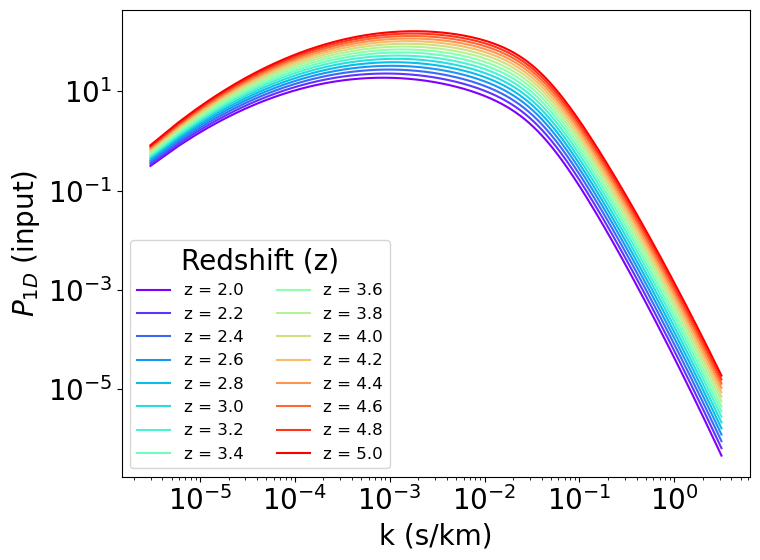

In [164]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

for z, xi in zip(zlist, p1d_edr_fit):
    color = cmap(norm(z))                                             # Get the corresponding color from the colormap
    plt.loglog(k_arr[1:], xi[1:], label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='lower left', ncol=2, title="Redshift (z)", fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ (input)')
plt.tight_layout()
plt.show()

Get the correlation function from input power model estimates:

In [165]:
xif_edr_fit = np.empty((zlist.size, numvpoints)) 

for i, z in enumerate(zlist):
    xif_edr_fit[i] = (np.fft.irfft(p1d_edr_fit[i]))[:numvpoints] / dv
    # xif_edr_fit[i] = np.fft.irfft(p1d_edr_fit[i], n=numvpoints) / dv


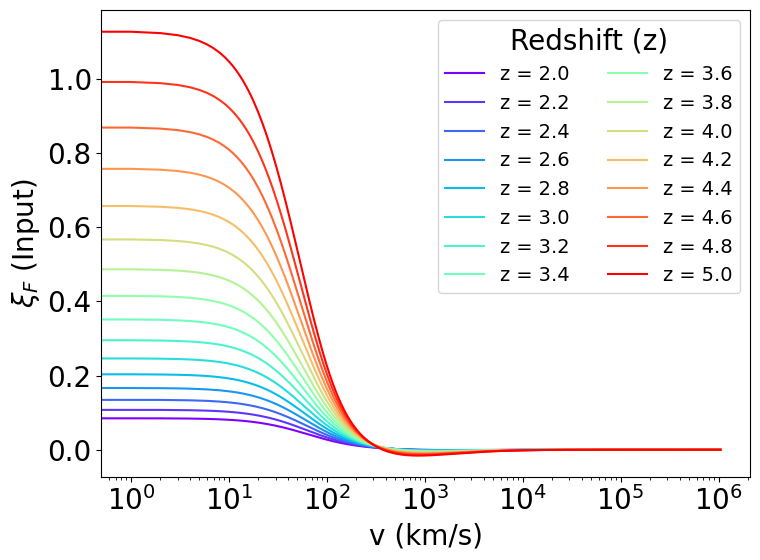

In [166]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

#################################################

# Plot the correlation function (F) for each z value
for z, xi in zip(zlist, xif_edr_fit):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plt.semilogx(v_array, xi, label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='upper right', ncol=2, title="Redshift (z)", fontsize=14)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (Input)')
# plt.title(r'$\xi_F$ EDR')
plt.tight_layout()
plt.show()
# plt.savefig('EDR_Correlation_Function')


In [167]:
# Set parameters for optimization
redshift_index = np.where(zlist == target_redshift)[0][0]
xi_f_target = xif_edr_fit[redshift_index]  
# xi_f target is just the xi_f EDR fit at a given redshift (e.g. 2.8)

print("redshift = " +str(zlist[redshift_index]))

redshift = 2.8


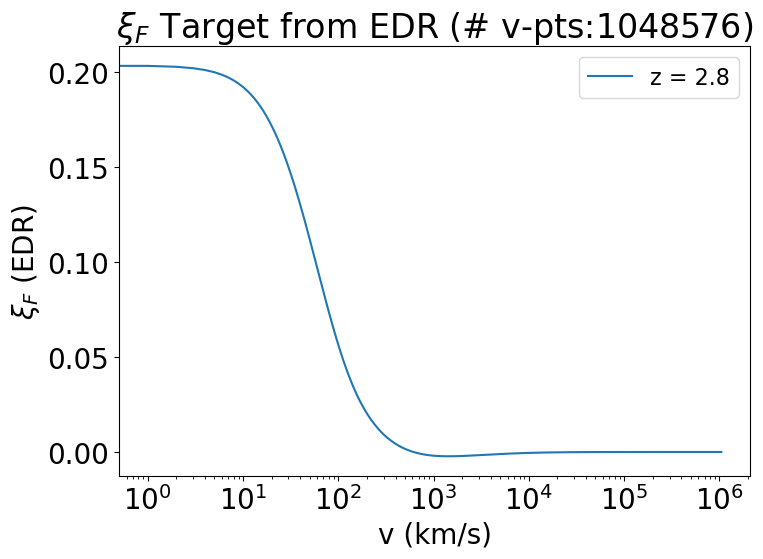

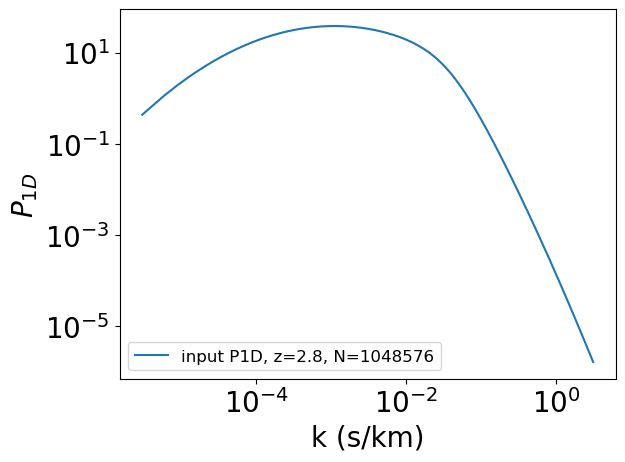

In [168]:
# locate z = 2.8 => zlist[4]
# plot only z = 2.8 for xi_F EDR data:

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(v_array, xif_edr_fit[redshift_index], label='z = '+str(zlist[redshift_index]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ Target from EDR (# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()
# plt.savefig('EDR_Correlation_Function_single_redshift')

# note: this is what we are trying to fit, by finding the optimal xi_g that gives 
#       the corresponding xi_f here 


plt.loglog(k_arr[1:], p1d_edr_fit[redshift_index][1:], label = 'input P1D, z='+str(zlist[redshift_index])+', N='+str(numvpoints))
plt.legend(fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ ')
plt.show()


New shape of interpolated data: (1048576,)


Text(0, 0.5, '$P_{1D}$ ')

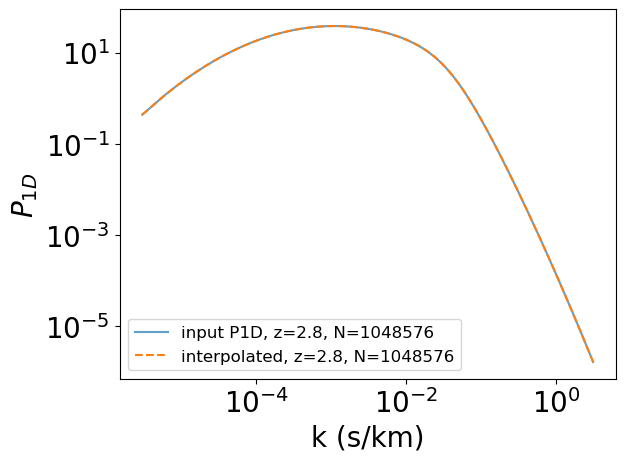

In [169]:

# liner interpolation of input power

# input arrays, selected above
p1d_input = p1d_edr_fit[redshift_index][1:]
k_array_input = k_arr[1:]

# Define the new number of points (e.g., 2^20)
new_size = 2**20
new_v_array = np.arange(new_size) * dv
# new_v_array = (np.arange(new_size) - new_size // 2) * dv

# Generate the new k_array with finer spacing
k_array_fine = np.linspace(k_array_input.min(), k_array_input.max(), new_size)

# Perform cubic spline interpolation
cs = CubicSpline(k_array_input, p1d_input)

# Evaluate at new k_array points
p1d_fine = cs(k_array_fine)

# Output: p1d_fine and k_array_fine now have the desired resolution
print("New shape of interpolated data:", p1d_fine.shape)  # Should be (2^20,)

plt.loglog(k_arr[1:], p1d_edr_fit[redshift_index][1:], label = 'input P1D, z='+str(zlist[redshift_index])+', N='+str(numvpoints), alpha=0.7)
plt.loglog(k_array_fine, p1d_fine, color='tab:orange', label='interpolated, z='+str(zlist[redshift_index])+', N='+str(new_size), ls='--')
plt.legend(fontsize=12)
plt.xlabel('k (s/km)')
plt.ylabel(r'$P_{1D}$ ')


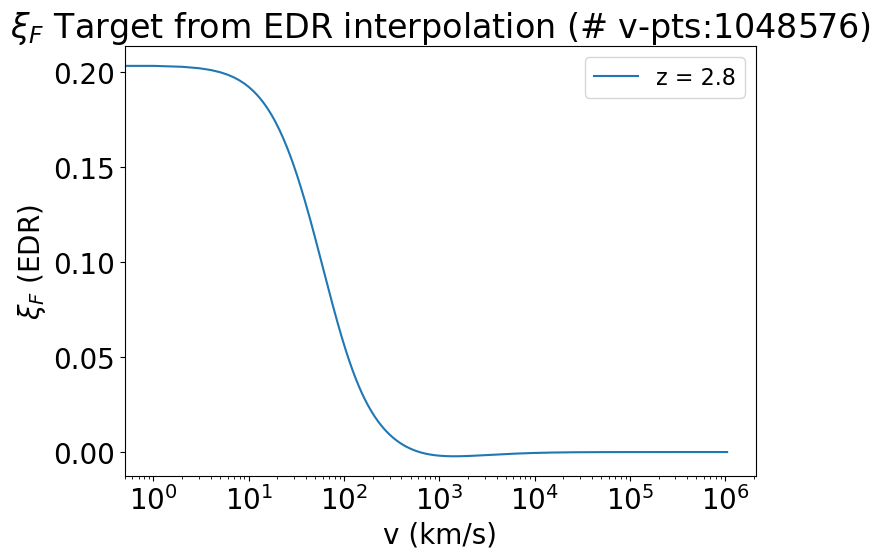

In [170]:

xif_interp_fit = (np.fft.irfft(p1d_fine))[:new_size] / dv

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(new_v_array, xif_interp_fit, label='z = '+str(zlist[redshift_index]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ Target from EDR interpolation (# v-pts:'+str(new_size)+')')
plt.legend(fontsize=16)
plt.tight_layout()

Now we need to downsample xif and v_array, to make the xif -> xig calculation manageable 

In [171]:

# sample logarithmically 
 
downsample_size = 2**6

# Step 1: Ensure velocity is positive (but include values close to zero)
velocity_abs = np.abs(new_v_array[1:])  # Ensure all values are positive, skip [0] to avoid v=0

# Step 2: Generate log(1+v)-spaced velocity points
log_v_min, log_v_max = np.log10(1 + velocity_abs.min()), np.log10(1 + velocity_abs.max())
v_array_downsampled = np.logspace(log_v_min, log_v_max, downsample_size) - 1  # Shift back

# Step 3: Interpolate using CubicSpline
cs = CubicSpline(velocity_abs, xif_interp_fit[1:])  # Create cubic spline interpolator
xif_target_downsampled = cs(v_array_downsampled)  # Evaluate at log(1+v)-spaced points

# Output the shapes
print("Downsampled velocity shape:", v_array_downsampled.shape)  # Should be (2^10,)
print("Downsampled xif shape:", xif_target_downsampled.shape)  # Should be (2^10,)
print("First velocity value:", v_array_downsampled[0])  # Should be small but nonzero

####################################################################

# Check if the spacing is constant (should not be)

dv_downsampled = np.diff(v_array_downsampled)  # Compute velocity spacing

print("\nMin spacing:", np.min(v_array_downsampled))
print("Max spacing:", np.max(v_array_downsampled))
print("Mean spacing:", np.mean(v_array_downsampled))

downsampled_dv = np.mean(v_array_downsampled)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(v_array_downsampled), np.max(v_array_downsampled), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Downsampled velocity shape: (64,)
Downsampled xif shape: (64,)
First velocity value: 0.9999995231628418

Min spacing: 0.9999995231628418
Max spacing: 1048574.5000004771
Mean spacing: 86851.73213051245
Velocity grid is NOT evenly spaced ❌


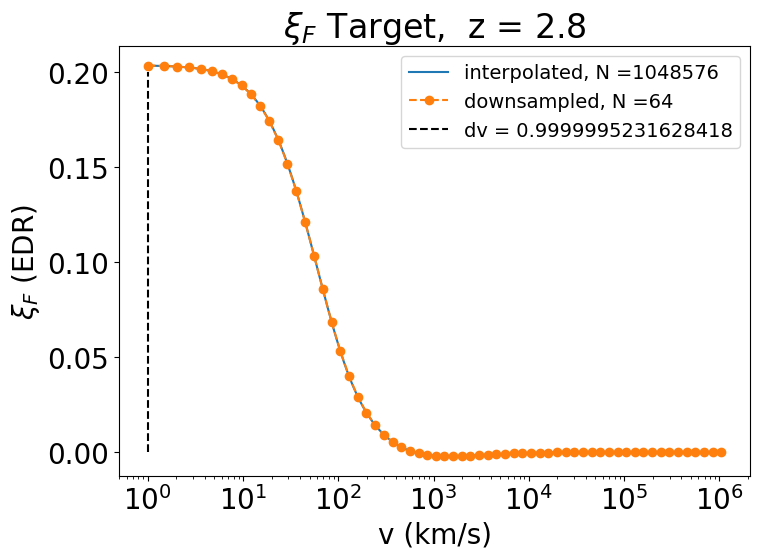

In [172]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})

plt.semilogx(new_v_array[1:], xif_interp_fit[1:], label='interpolated, N =' +str(new_size))
plt.semilogx(v_array_downsampled, xif_target_downsampled, label='downsampled, N =' +str(downsample_size), ls='--', marker='o')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$ (EDR)')
plt.title(r'$\xi_F$ Target,  z = '+str(zlist[redshift_index]))
plt.vlines(dv, 0, 0.20, color='black', ls='--', label='dv = '+str(dv))
# plt.vlines(10, 0, 0.20, color='grey', ls='--', label='dv = '+str(10))
# plt.vlines(0, 0, 0.20, color='red', ls='--', label='v = 0')
plt.legend(fontsize=14)

# plt.xlim(10e-2,10e2)

# plt.xlim(0-1, new_v_array.size)
plt.tight_layout()

Now solve for xi_G using downsampled xi_F target

In [173]:

# xi_f_target = xif_target_downsampled

# ####################################################################

# time_1 = time.strftime("%H:%M:%S")
# print("Start Time: ", time_1)
# start_time = time.time()

# ####################################################################

# # Define the objective function for fsolve
# def objective(xi_g, z, xi_f_target):
#     """
#     Compute the difference between the target xi_f values and the xi_f values
#     calculated from xi_g using lognXiFfromXiG_pointwise.

#     Parameters
#     ----------
#     xi_g : array-like
#         Current guess for xi_g values.
#     z : float
#         Redshift at which xi_f is calculated.
#     xi_f_target : array-like
#         Target xi_f values, in this case, xif_edr_fit.

#     Returns
#     -------
#     array-like
#         Residuals between calculated and target xi_f.
#     """
#     xi_f_calculated = np.array([lognXiFfromXiG_pointwise(z, xi_g_i) for xi_g_i in xi_g])
#     return xi_f_calculated - xi_f_target

# xi_g_initial_guess = np.full(xi_f_target.size, 0.1)

# result = least_squares(objective, xi_g_initial_guess, args=(zlist[redshift_index], xi_f_target))#, method=fitting_method, tr_solver=solver_method)
# xi_g_optimized = result.x

# ####################################################################

# time_2 = time.strftime("%H:%M:%S")
# print("End Time: ", time_2)

# end_time = time.time()  # Get the new current time in seconds
# elapsed_time = end_time - start_time  # Calculate elapsed time
# # Convert elapsed time to minutes and seconds
# minutes = int(elapsed_time // 60)
# seconds = int(elapsed_time % 60)
# print(f"Elapsed Time: {minutes} min {seconds} sec")
# print("Size = "+str(downsample_size))

# ####################################################################


In [192]:

xi_f_target = xif_target_downsampled

# Split indices: where velocity is above threshold
cutoff_v = 10.0
v_fit_mask = v_array_downsampled >= cutoff_v

v_fit = v_array_downsampled[v_fit_mask]
xi_f_fit = xi_f_target[v_fit_mask]

xi_g_initial_guess = np.full(xi_f_fit.size, 0.1)

def objective(xi_g, z, xi_f_target_subset):
    xi_f_calculated = np.array([lognXiFfromXiG_pointwise(z, xi_g_i, *mini.values) for xi_g_i in xi_g])
    return xi_f_calculated - xi_f_target_subset

##################################

time_1 = time.strftime("%H:%M:%S")
print("Start Time: ", time_1)
start_time = time.time()

result = least_squares(objective, xi_g_initial_guess, 
                       args=(zlist[redshift_index], xi_f_fit))
xi_g_fit = result.x

# Create extrapolator (can use linear or cubic, just ensure fill_value='extrapolate')
xi_g_extrapolator = interp1d(
    v_fit, xi_g_fit, kind='linear', 
    fill_value='extrapolate', 
    bounds_error=False
)

# Apply to full array
xi_g_full = xi_g_extrapolator(v_array_downsampled)

time_2 = time.strftime("%H:%M:%S")
print("End Time: ", time_2)

end_time = time.time()  # Get the new current time in seconds
elapsed_time = end_time - start_time  # Calculate elapsed time
# Convert elapsed time to minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
print(f"Elapsed Time: {minutes} min {seconds} sec")
print("Size = "+str(downsample_size))

##################################




Start Time:  08:07:26
End Time:  08:07:33
Elapsed Time: 0 min 7 sec
Size = 64


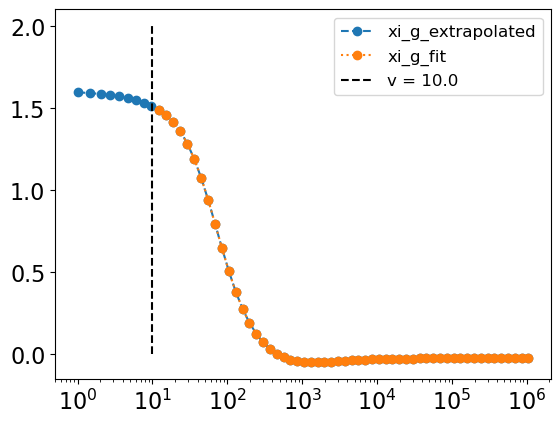

In [193]:
plt.semilogx(v_array_downsampled, xi_g_full, 'o', label='xi_g_extrapolated', ls='--')
plt.semilogx(v_fit, xi_g_fit, 'o', label='xi_g_fit', ls='dotted')
# plt.xlim(0,20)
plt.vlines(cutoff_v, 0, 2, color='black', ls='--', label=f'v = {cutoff_v}')
plt.legend(fontsize=12)

In [194]:
np.isclose(objective(xi_g_fit, zlist[redshift_index], xi_f_target[v_fit_mask]), 0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [195]:
# np.isclose(objective(xi_g_optimized, zlist[redshift_index], xi_f_target), 0)
np.isclose(objective(xi_g_full, zlist[redshift_index], xi_f_target), 0)

array([False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [196]:
zero_point = xi_g_full[0]

print(f"Input sigma2 from mean Flux:    {mini.values['sigma2']}")
print(f"Calculated sigma2 from Xi_G(0): {xi_g_fit[0]}")
print(f"Difference:                     {np.abs(mini.values['sigma2']-xi_g_fit[0])}\n")

print(f"Extrapolated zero point:        {zero_point}")
print(f"Difference:                     {np.abs(mini.values['sigma2']-zero_point)}")


Input sigma2 from mean Flux:    1.5038053361999801
Calculated sigma2 from Xi_G(0): 1.4891450350978412
Difference:                     0.014660301102138895

Extrapolated zero point:        1.5970114987624868
Difference:                     0.09320616256250669


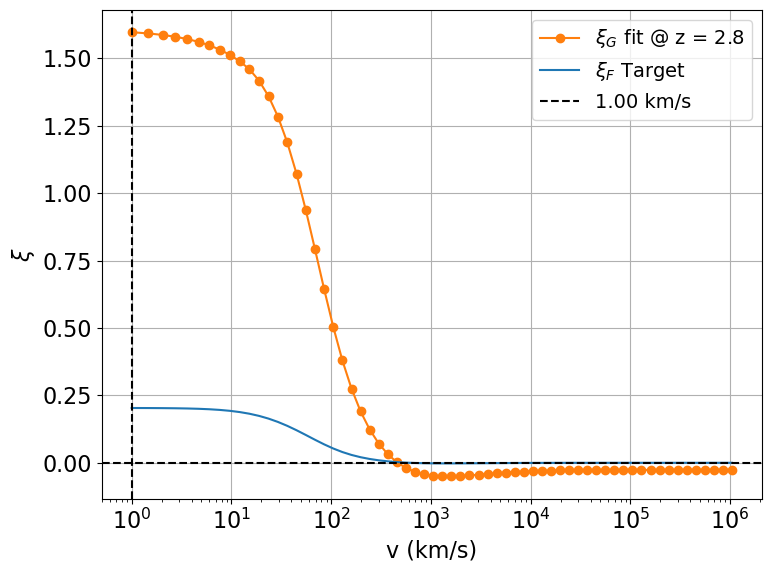

In [179]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(v_array_downsampled, xi_g_full, color='tab:orange', marker='o', label= r'$\xi_G$ fit @ z = '+str(zlist[redshift_index]))
# plt.vlines(dv, 0, 2, ls='--', color='black', label='dv = '+str(dv))

plt.semilogx(v_array_downsampled, xi_f_target, label = r'$\xi_F$ Target', color = 'tab:blue', alpha=1.0)
# plt.semilogx(v_array_downsampled, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:green", ls='none', marker='o', alpha=0.4)

plt.axhline(y=0.0, color='black', linestyle='--')
plt.axvline(x=dv, color='black', linestyle='--', label=f"{dv:.2f} km/s")
# plt.axvline(x=10, ls='--', color='grey', label='v = '+str(10))

plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.legend(fontsize=14)
plt.tight_layout()
plt.grid()

# plt.savefig('xiG_Fit')

In [180]:
# plt.figure(figsize=(8, 6))
# plt.rcParams.update({'font.size': 16})

# plt.semilogx(v_array_downsampled, xi_g_full, color='tab:orange', marker='o', label= r'$\xi_G$ fit @ z = '+str(zlist[redshift_index]))
# plt.vlines(dv, 0, 2, ls='--', color='black', label='dv = '+str(dv))

# plt.xlabel('v (km/s)')
# plt.ylabel(r'$\xi$')
# plt.title('downsampled fit (# v-pts:'+str(downsample_size)+') - method: least squares')
# plt.legend(fontsize=14)
# plt.tight_layout()
# plt.grid()

Now calculate xi_f optimized / fit from xi_g_fit

In [186]:
xi_f_optimized = np.array([lognXiFfromXiG_pointwise(zlist[redshift_index], xi_g_i, *mini.values) for xi_g_i in xi_g_full])

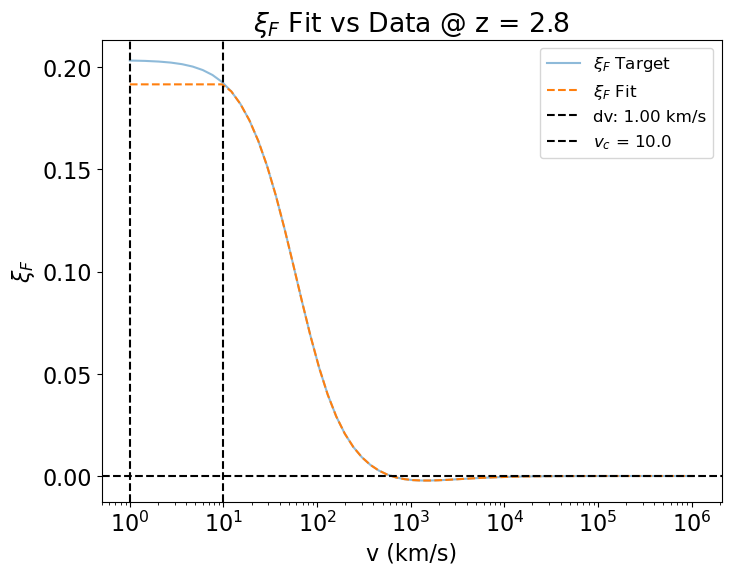

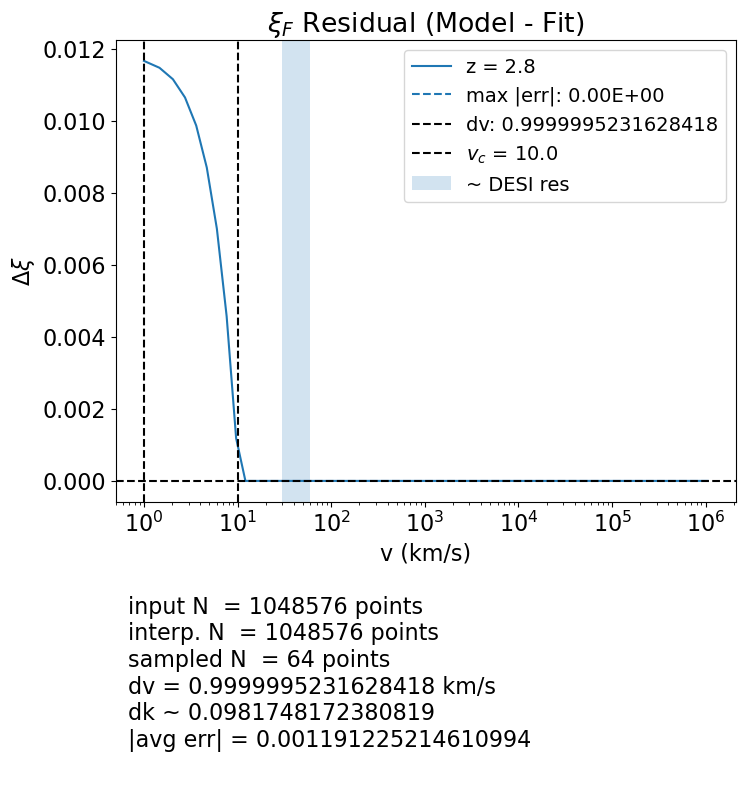

In [182]:
# plot xi F

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

##############################################

dif_xi_f = xi_f_target - xi_f_optimized
abs_dif_xi_f = np.abs(dif_xi_f)

max_y = dif_xi_f[np.argmax(abs_dif_xi_f)]  # This gives the actual value (+/-) farthest from 0
max_x = v_array[np.argmax(abs_dif_xi_f)]

##############################################

plt.semilogx(v_array_downsampled, xi_f_target, label = r'$\xi_F$ Target', color = 'tab:blue', alpha=0.5)
# plt.semilogx(v_array_downsampled, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:orange", ls='--', marker='o')
plt.semilogx(v_array_downsampled, xi_f_optimized, label=r"$\xi_F$ Fit", color="tab:orange", ls='--')

plt.axhline(y=0.0, color='black', linestyle='--')
plt.axvline(x=dv, color='black', linestyle='--', label=f"dv: {dv:.2f} km/s")
# plt.axvline(x=10, ls='--', color='grey', label='v = '+str(10))
# plt.axvline(x=150, ls='--', color='red', label='v = '+str(150))
# plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
plt.legend(fontsize=12)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.title(r"$\xi_F$ Fit vs Data @ z = "+str(zlist[redshift_index]))
plt.show()

##############################################

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(v_array_downsampled, dif_xi_f, label = 'z = '+str(zlist[redshift_index]), color = 'tab:blue')
plt.axhline(y=0.0, color='black', linestyle='--')
plt.axvline(x=max_x, color='tab:blue', linestyle='--', label=f"max |err|: {max_x:.2E}")
plt.axvline(x=dv, color='black', linestyle='--', label=f"dv: {dv}")
# plt.axvline(x=10, ls='--', color='grey', label='v = '+str(10))
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
plt.axvspan(30, 60, alpha=0.2, label='~ DESI res')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\Delta \xi$')
plt.legend(fontsize=14)
plt.title(r"$\xi_F$ Residual (Model - Fit)")

txt11 = "input N  = "+str(numvpoints)+" points \n"
txt12 = "interp. N  = "+str(new_size)+" points \n"
txt13 = "sampled N  = "+str(downsample_size)+" points \n"
txt2 = "dv = "+str(dv)+" km/s \n"
txt3 = "dk ~ "+str(2*np.pi/((v_array_downsampled.size)*dv)) + '\n'
txt5 = "|avg err| = " + str(np.abs(np.average(dif_xi_f))) + '\n'
# txt6 = "max err = " + str(max_y) + " at v = " + str(max_x) + "km/s \n"
txt  =  txt11 + txt12 + txt13 + txt2 + txt3 + txt5 #+ txt6 #+ txt4 

plt.text(0.02, -0.4, txt, ha='left', va='center', transform=plt.gca().transAxes)
plt.show()

In [183]:
mini.values

<ValueView tau0=0.6737651580016017 tau1=5.310084075374157 nu=2.161750475695124 sigma2=1.5038053361999801>

In [184]:
# from scipy.interpolate import interp1d

# # v_array_downsampled, xi_g_optimized

# # Example data (replace with real values)
# v_values = v_array_downsampled
# xi_g_values = xi_g_full

# # Create a linear interpolator with extrapolation
# linear_extrapolator = interp1d(v_values, xi_g_values, kind='linear', fill_value="extrapolate")

# # Compute xi_g at v=0
# xi_g_at_v0 = linear_extrapolator(0)

# print(f"Extrapolated xi_g at v=0: {xi_g_at_v0}")


## Extrapolating xi_g to get the full xi_g

In [185]:
xi_f_target[0]

0.20324297151832965

zero val: 1.6189195833553869


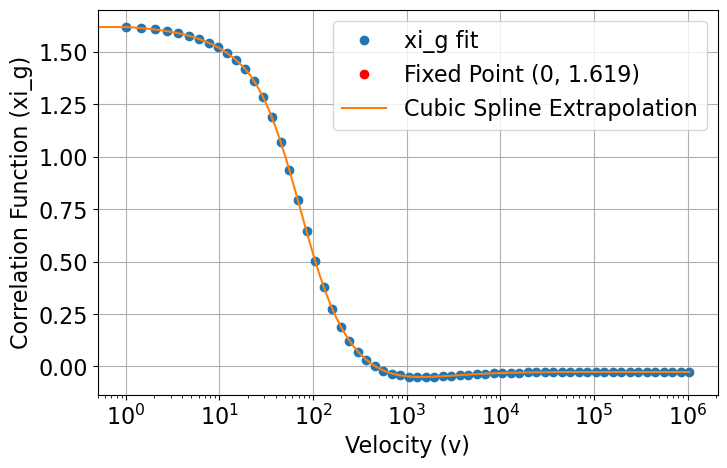

In [47]:

# Define the new velocity array: log-spaced including v=0
v_extrapolated = np.logspace(np.log10(1), np.log10(max(v_array_downsampled)), num=100)  # Start from 1 (to avoid log(0))
v_extrapolated = np.insert(v_extrapolated, 0, 0)  # Manually insert v=0

# Insert the fixed point (at v=0)
# zero_val = 0.45
zero_val = zero_point
print(f'zero val: {zero_val}')
xi_g_new_vals = np.insert(xi_g_full, 0, zero_val)
v_extended = np.insert(v_array_downsampled, 0, 0)

###########################################################

# Create cubic spline interpolation with extrapolation
spline = CubicSpline(v_extended, xi_g_new_vals, bc_type='natural')

# Compute the extrapolated xi_g values
xi_g_extrapolated = spline(v_extrapolated)

#############################################################

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(v_array_downsampled, xi_g_full, 'o', label='xi_g fit')
plt.plot(0, zero_val, 'ro', label=f'Fixed Point (0, {zero_val:.3f})')
plt.plot(v_extrapolated, xi_g_extrapolated, '-', label='Cubic Spline Extrapolation')
plt.xscale('log')  # Log-scale to visualize properly
# plt.xlim([-0.1,100])
plt.xlabel('Velocity (v)')
plt.ylabel('Correlation Function (xi_g)')
plt.legend(loc='upper right')
plt.grid()
plt.show()


#### check that xi_f is recovered

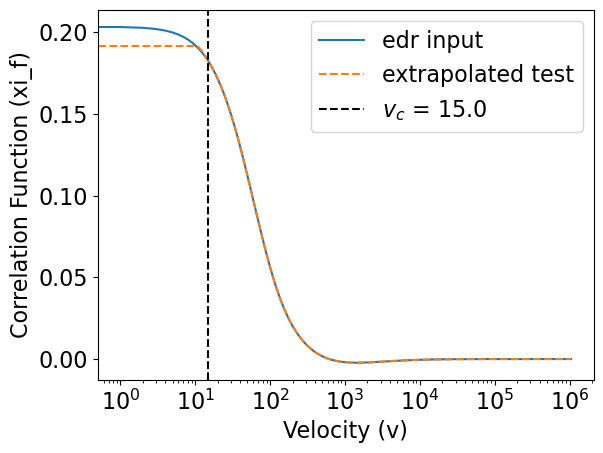

In [48]:
xi_f_optimized_extrapolated = np.array([lognXiFfromXiG_pointwise(zlist[redshift_index], xi_g_i, *mini.values) for xi_g_i in xi_g_extrapolated])

plt.semilogx(v_array, xif_edr_fit[redshift_index], label='edr input')
plt.semilogx(v_extrapolated, xi_f_optimized_extrapolated, label='extrapolated test', ls='--')
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
# plt.xlim(10e-2, 10e2)
plt.xlabel('Velocity (v)')
plt.ylabel('Correlation Function (xi_f)')
plt.legend()

Oversampled velocity shape: (1048576,)
Oversampled xif shape: (1048576,)


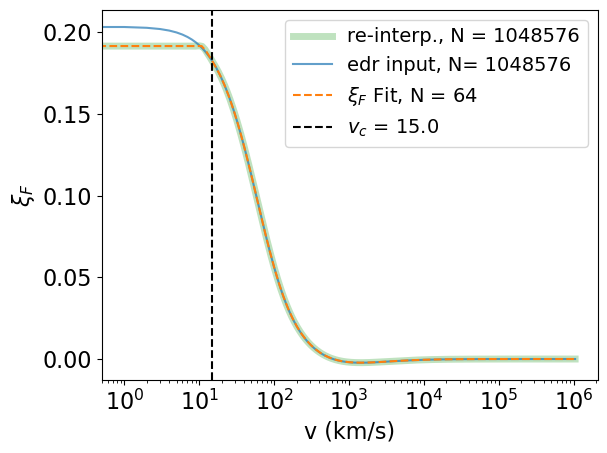

In [49]:

# interpolate the extrapolated xi_f

# Step 1: Generate the original (fine) velocity array (2^20 points)
v_fine = np.linspace(v_extrapolated.min(), v_extrapolated.max(), 2**20)  # Linearly spaced

# Step 2: Interpolate xig onto the fine velocity grid
cs = CubicSpline(v_extrapolated, xi_f_optimized_extrapolated)  # Create cubic spline interpolator
xif_fine = cs(v_fine)  # Evaluate at fine velocity points

# Output: xig_fine and v_fine now contain 2^20 points
print("Oversampled velocity shape:", v_fine.shape)  # Should be (2^20,)
print("Oversampled xif shape:", xif_fine.shape)  # Should be (2^20,)

plt.semilogx(v_fine, xif_fine, label='re-interp., N = '+str(v_fine.size), color='tab:green', lw=5, alpha=0.3)
plt.semilogx(v_array, xif_edr_fit[redshift_index], label='edr input, N= '+str(v_array.size), color = 'tab:blue', alpha=0.7)
plt.semilogx(v_extrapolated, xi_f_optimized_extrapolated, label=r"$\xi_F$ Fit, N = "+str(xi_f_optimized.size), color="tab:orange", ls='--')
plt.axvline(cutoff_v, color='black', ls='--', label=rf'$v_c$ = {cutoff_v}')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.legend(fontsize=14)
# plt.title(r"$\xi_F$ Residual (EDR - Fit)")

In [50]:
# check new velocity spacing

dv_fine = np.diff(v_fine) 

# Check if the spacing is constant
print("Min spacing:", np.min(dv_fine))
print("Max spacing:", np.max(dv_fine))
print("Mean spacing:", np.mean(dv_fine))

new_dv = np.mean(dv_fine)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(dv_fine), np.max(dv_fine), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Min spacing: 0.9999995231628418
Max spacing: 0.9999995231628418
Mean spacing: 0.9999995231628418
Velocity grid is evenly spaced ✅


## get P_G from xi_G using curvefit

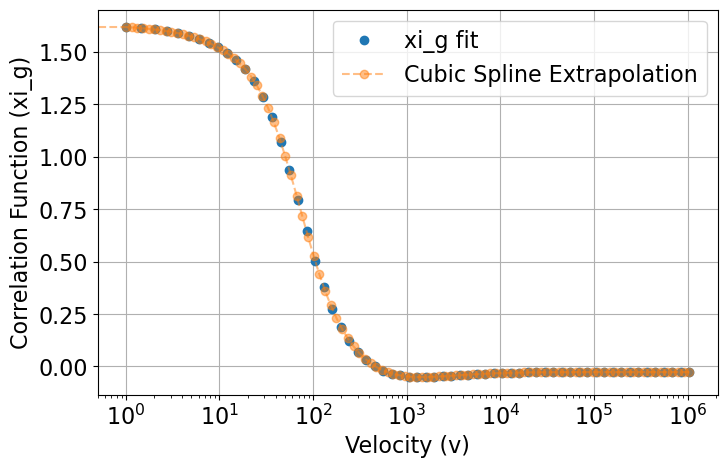

In [51]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(v_array_downsampled, xi_g_full, 'o', label='xi_g fit')
# plt.plot(0, 1.55, 'ro', label='Fixed Point (0,'+str(zero_val)+')')
plt.plot(v_extrapolated, xi_g_extrapolated, '--', label='Cubic Spline Extrapolation',marker= 'o', alpha=0.5)
plt.xscale('log')  # Log-scale to visualize properly
plt.xlabel('Velocity (v)')
plt.ylabel('Correlation Function (xi_g)')
plt.legend()
plt.grid()
plt.show()


Oversampled velocity shape: (1048576,)
Oversampled xig shape: (1048576,)


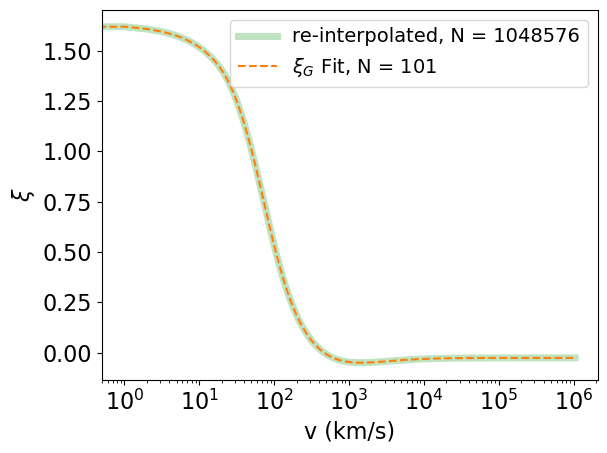

In [52]:
# interpolate the extrapolated xi_g fit to get even spacing 

# Step 1: Generate the original (fine) velocity array (2^20 points)
v_fit_fine = np.linspace(v_extrapolated.min(), v_extrapolated.max(), 2**20)  # Linearly spaced

# Step 2: Interpolate xig onto the fine velocity grid
cs = CubicSpline(v_extrapolated, xi_g_extrapolated)  # Create cubic spline interpolator
xi_g_fit_fine = cs(v_fit_fine)  # Evaluate at fine velocity points

# Output: xig_fine and v_fine now contain 2^20 points
print("Oversampled velocity shape:", v_fit_fine.shape)  # Should be (2^20,)
print("Oversampled xig shape:", xi_g_fit_fine.shape)  # Should be (2^20,)

plt.semilogx(v_fit_fine, xi_g_fit_fine, label='re-interpolated, N = '+str(xi_g_fit_fine.size), color='tab:green', lw=5, alpha=0.3)
plt.semilogx(v_extrapolated, xi_g_extrapolated, label=r"$\xi_G$ Fit, N = "+str(xi_g_extrapolated.size), color="tab:orange", ls='--')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.legend(fontsize=14)
# plt.title(r"$\xi_F$ Residual (EDR - Fit)")

In [53]:
dv_fit_fine = np.diff(v_fit_fine)  # Compute velocity spacing

# Check if the spacing is constant
print("Min spacing:", np.min(dv_fit_fine))
print("Max spacing:", np.max(dv_fit_fine))
print("Mean spacing:", np.mean(dv_fit_fine))

fit_xig_dv = np.mean(dv_fit_fine)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(dv_fit_fine), np.max(dv_fit_fine), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Min spacing: 0.9999995231628418
Max spacing: 0.9999995231628418
Mean spacing: 0.9999995231628418
Velocity grid is evenly spaced ✅


In [54]:
def mirror_xiG(safe_z, half_v, half_xig): 
    file_v = half_v        # First column
    file_xiG = half_xig   # Second column

    def truncate_trailing_zeros(x, y):
        # Find the last index where y is nonzero
        last_nonzero_index = np.max(np.nonzero(y))

        # Ensure at least one zero remains at the end
        if last_nonzero_index < len(y) - 1 and y[last_nonzero_index + 1] == 0:
            last_nonzero_index += 1  # Keep the first zero after the last nonzero value

        return x[:last_nonzero_index + 1], y[:last_nonzero_index + 1]

    # v_truncated, xiG_truncated = truncate_trailing_zeros(file_v, file_xiG)
    v_truncated, xiG_truncated = file_v, file_xiG

    # Interpolate linearly (constant dv)
    file_v_fine = np.linspace(v_truncated.min(), v_truncated.max(), 2**20)
    cs = CubicSpline(v_truncated, xiG_truncated)
    file_xi_g_fine = cs(file_v_fine)

    dv_fit_fine = np.diff(file_v_fine)
    v_spacing = np.mean(dv_fit_fine)

    v_full = np.concatenate(
        [file_v_fine, file_v_fine + file_v_fine[-1] + v_spacing])

    # Mirror the correlation function values
    xig_full = np.concatenate([file_xi_g_fine, file_xi_g_fine[::-1]])

    return file_v_fine, file_xi_g_fine, v_full, xig_full

def calc_PG(safe_z, v_array, xig_array):
    full_v = v_array
    full_xiG = xig_array
    full_v_spacing = full_v[1] - full_v[0]

    # Compute power spectrum
    file_xig_power = np.fft.rfft(full_xiG) * full_v_spacing
    file_xig_power = np.abs(file_xig_power)  # np.abs vs .real ?
    file_xig_karr = 2 * np.pi * \
        np.fft.rfftfreq(len(full_xiG), d=full_v_spacing)

    return file_xig_karr, file_xig_power

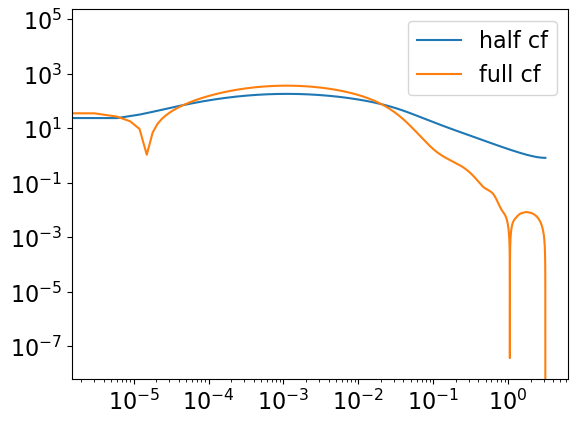

In [55]:
v_half, xig_half, v_full, xig_full = mirror_xiG(safe_z='2-8', half_v= v_extrapolated, half_xig=xi_g_extrapolated)

k_array_half, power_array_half = calc_PG(safe_z='2-8', v_array=v_half, xig_array=xig_half)
k_array_full, power_array_full = calc_PG(safe_z='2-8', v_array=v_full, xig_array=xig_full)

plt.loglog(k_array_half, power_array_half, label='half cf')
plt.loglog(k_array_full, power_array_full, label='full cf')
plt.legend()

#### gen test

In [105]:

# target_redshift = 2.8
safe_z = str(target_redshift).replace('.', '-')

####################################

seed = 100     # for repeatability
size = 2**22
dv   = 1.0
# dv = 0.5

c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

# fitting parameters from mean flux           
tau0_fid   = mini.values['tau0']
tau1_fid   = mini.values['tau1']
nu_fid     = mini.values['nu']
sigma2_fid = mini.values['sigma2']


In [106]:

#### FUNCTIONS ####

def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # real-space size
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k [1/km]
    
    # Interpolate with smooth spline and constant extrapolation
    power_interp = InterpolatedUnivariateSpline(file_k_array, 
                                                file_power_array, 
                                                k=1, ext=1)
    P_k = power_interp(k)

    # Ensure non-negative and finite
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)

    # Scale the white noise in k-space
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse FFT to get real-space correlated Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N) / dv

    return delta_b_tilde, delta_b, P_k


def a2_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)


def a_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))


# note: variance of the field, vs the one set by mean flux (?)
def lognormal_transform(delta_z, sigma2_z):
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)


def t_of_z(zp, tau0=tau0_fid, tau1=tau1_fid, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)


def x_of_z(t_z, n_z):
    return t_z * n_z


def f_of_z(x_z):
    return np.exp(-x_z)


def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)


def xz(z, sigma2=sigma2_fid, tau0=tau0_fid, tau1=tau1_fid, 
       nu=nu_fid, z0=PD13_PIVOT_Z):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)


def mean_flux(z, variance, z0=PD13_PIVOT_Z):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - 
                                 ((xz(z)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)


def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)


def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = input_flux.mean()
    # f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)


def P_F(delta_f, dv):
    L = delta_f.size * dv
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / L
    return P_F


def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f, dv)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # w_k =  (kmodes > 0) & (kmodes < 10e1)   
    w_k =  (kmodes > 0) & (kmodes < 10e2)   
    bins = 20000
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[w_k],
                                                       values=power[w_k],
                                                       statistic='mean', 
                                                       bins = bins)    
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
 
    window = (bin_centers > 0) & (bin_centers < 1.0)  

    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)
    
    return bin_centers[window], statistic[window], *popt_mock
    # return bin_centers, statistic, *popt_mock


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


# DESI_EDR_PARAMETERS = (
#     0.066, -2.685, -0.22,
#     3.59, -0.16, 0.053) # from 2023 edr paper
# DESI_EDR_PARAMETERS = (
#     7.63089e-02, -2.52054e+00, -1.27968e-01,
#     3.67469e+00, 2.85951e-01, 7.33473e+02)


Naim_2020_param = (
    0.066, -2.685, -0.22, 
    3.59, -0.18, 0.53)

In [125]:
#### MOCK GENERATION ####

# gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field = np.random.default_rng().normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) #+ 1e-12 


delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array_full, power_array_full, gaussian_random_field_k, dv)

variance_1d = sigma2_fid
variance_1d_field = delta_b_v.var()

delta_b_z = delta_b_v * a_z(zp = target_redshift)

redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)
redshifted_variance_1d_field = variance_1d_field * a2_z(zp = target_redshift)

# n_z = lognormal_transform(delta_b_z, variance_1d)
n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
# n_z = lognormal_transform(delta_b_z, redshifted_variance_1d_field)
# n_z = lognormal_transform(delta_b_z, variance_1d_field)
t_z = t_of_z(zp=target_redshift)
x_z = x_of_z(t_z, n_z)
f_z = f_of_z(x_z)



In [126]:
print(f'variance_1d:       {variance_1d}')
print(f'variance_1d_field: {variance_1d_field}\n')

print(f'redshifted_variance_1d:       {redshifted_variance_1d}')
print(f'redshifted_variance_1d_field: {redshifted_variance_1d_field}')

variance_1d:       1.5038053361999801
variance_1d_field: 1.66057452647443

redshifted_variance_1d:       1.6801483447694692
redshifted_variance_1d_field: 1.855300998646899


In [127]:

#### MEASURE POWER ####

# delta_f = delta_F(z=target_redshift, 
#                   variance=variance_1d, 
#                   input_flux=f_z)
delta_f = delta_F(z = target_redshift, 
                  variance = variance_1d_field, 
                  input_flux = f_z)

test_power = P_F(delta_f, dv)

bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, 
                                                      target_redshift)

mock_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *popt_mock_param)
desi_model = evaluatePD13Lorentz((bin_centers, target_redshift), 
                                 *DESI_EDR_PARAMETERS)
naim_fit = evaluatePD13Lorentz((bin_centers, target_redshift), 
                               *Naim_2020_param)

percent_diff_mock_measure = 100 * (stat - desi_model) / desi_model
percent_diff_mock_fit     = 100 * (mock_fit - desi_model) / desi_model
percent_diff_naim_fit     = 100 * (naim_fit - desi_model) / desi_model


/tmp/ipykernel_1722381/3627792979.py:129: RuntimeWarning: overflow encountered in power
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_1722381/3627792979.py:129: RuntimeWarning: overflow encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)


In [128]:
c = 299792.458        # km/s
delta_lambda = 0.8    # Angstrom (DESI)
lambda_lya = 1215.67  # Angstrom

def get_k_range_desi2025(z):
    """Return kmin and kmax (in s/km) for DESI DR1 resolution at redshift z."""
    R_z = (c * delta_lambda) / ((1 + z) * lambda_lya)
    k_max = 0.5 * np.pi / R_z  # s/km
    k_min = 0.001  # s/km, fixed by continuum limit
    return k_min, k_max
dynamic_k_min, dynamic_k_max = get_k_range_desi2025(target_redshift)


# 2020 mock paper k-range
wk_2020 = (bin_centers > 0.0005) & (bin_centers < 0.112)

# EDR measurement k-range
wk_2023 = (bin_centers > 0.000750) & (bin_centers < 0.035) # EDR measurement 

# 2025 measurement k-range
wk_2025 = (bin_centers > dynamic_k_min) & (bin_centers < dynamic_k_max)

# extended range
wk_extended = (bin_centers > 1e-5) & (bin_centers < 0.1) 

# custom, for display only
wk_custom = (bin_centers > 1e-4) & (bin_centers < 0.05) 


Mean: 20.22%


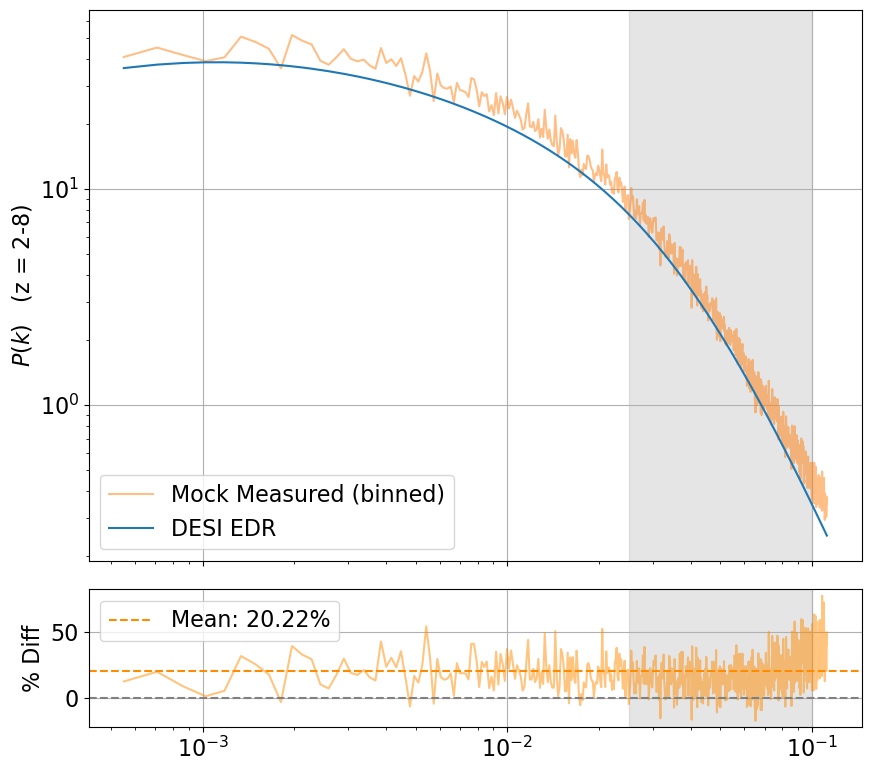

In [136]:

#### PLOT MEASURED POWER ####

w_k = wk_2020
# w_k = wk_extended
# w_k = wk_extended

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, 
                                    gridspec_kw={'height_ratios': [4, 1]})

ax1.loglog(bin_centers[w_k], stat[w_k], color='tab:orange', 
           label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
           color='tab:blue', label=r'DESI EDR')


# ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.set_ylabel(rf'$P(k)$   (z = {safe_z})')
ax1.legend(loc='lower left')
ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')
ax1.axvspan(0.025, 0.1, alpha=0.2, color='grey')


ax2.semilogx(bin_centers[w_k], percent_diff_mock_measure[w_k], alpha=0.5,
             color='darkorange')
ax2.axhline(percent_diff_mock_measure[w_k].mean(), ls='--', color='darkorange', 
            label=f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')
ax2.axhline(0, ls='--', color='gray')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')
ax2.axvspan(0.025, 0.1, alpha=0.2, color='grey')

plt.legend()
plt.tight_layout()

print(f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')


Compare to desi edr data points

In [130]:
import pandas as pd

edr_data_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Examples/figure8_qmle_desiedrp_results.txt'

# Read the file, using '|' as a separator and stripping whitespace
df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
df = df.apply(pd.to_numeric)               # Ensure all data is numeric

# Group by redshift and plot
# plt.figure(figsize=(8, 6))
# for z_val, group in df.groupby('z'):
#     plt.errorbar(group['kc'], group['kPpi'], yerr=group['kepi'], fmt='o-', label=f'z = {z_val}')

# plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
# plt.ylabel(r'$kP_{\pi}(k)$')
# plt.title("Power spectrum vs $k$ at different redshifts")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [131]:
z_target = target_redshift
subset = df[df['z'] == z_target].copy()

# Recover P(k) and its uncertainty
subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

# # Plot
# plt.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], fmt='o-', label=f'z = {z_target}')
# plt.xlabel(r'$k$ [$\mathrm{km}^{-1}\,\mathrm{s}$]')
# plt.ylabel(r'$P(k)$')
# plt.title(f"Recovered Power Spectrum $P(k)$ at $z={z_target}$")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()

# print(f'kmin = {subset['kc'][:].min()}')
# print(f'kmax = {subset['kc'][:].max()}')



In [132]:
def process_EDR_DATA(z_target):
    edr_data_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Examples/figure8_qmle_desiedrp_results.txt'

    # Read the file, using '|' as a separator and stripping whitespace
    df = pd.read_csv(edr_data_path, sep='|', skiprows=1)
    df = df.drop(columns=df.columns[[0, -1]])  # Drop extra empty columns from leading/trailing pipes
    df.columns = ['kc', 'z', 'kPpi', 'kepi']   # Rename columns
    df = df.apply(pd.to_numeric)               # Ensure all data is numeric

    subset = df[df['z'] == z_target].copy()
    
    # Recover P(k) and its uncertainty
    subset['Pk'] = np.pi * subset['kPpi'] / subset['kc']
    subset['Pk_err'] = np.pi * subset['kepi'] / subset['kc']

    return subset['kc'], subset['Pk'], subset['Pk_err']

test_edr_k, test_edr_p, test_edr_err = process_EDR_DATA(target_redshift)

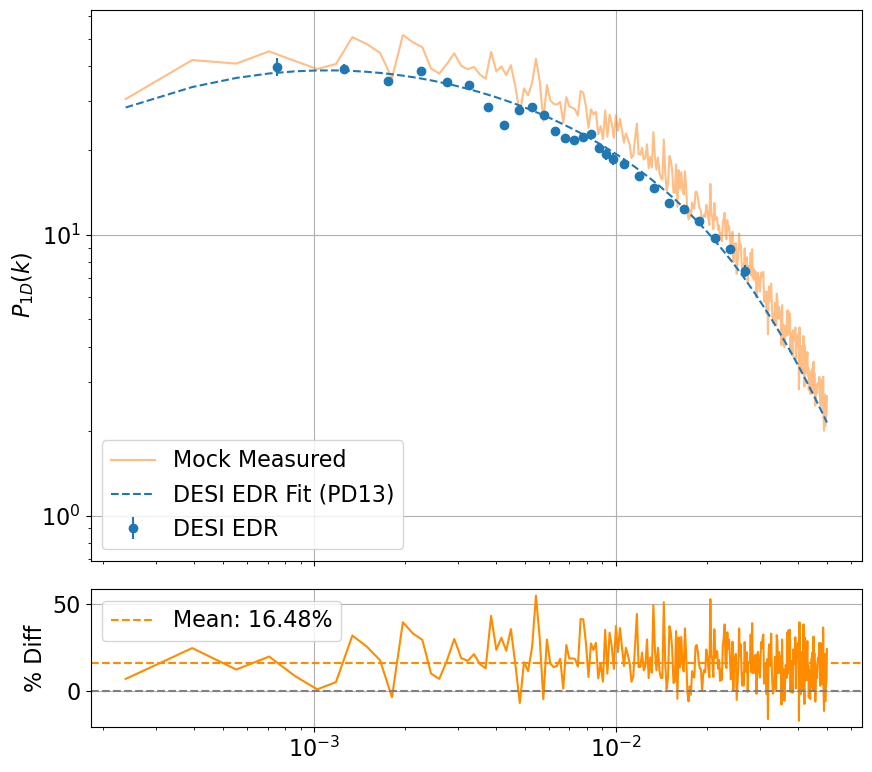

In [133]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# mask = (bin_centers > 1e-5) & (bin_centers < 0.1) 
# mask = (bin_centers > 1e-3) & (bin_centers < 0.045) # EDR measurement 
mask = (bin_centers > 1e-4) & (bin_centers < 0.05)  # custom




# Upper plot
ax1.loglog(bin_centers[mask], stat[mask], color='tab:orange', label='Mock Measured', alpha=0.5)
ax1.loglog(bin_centers[mask], desi_model[mask], 
    color='tab:blue', label=r'DESI EDR Fit (PD13)', ls='--')
ax1.errorbar(subset['kc'], subset['Pk'], yerr=subset['Pk_err'], 
             fmt='o', label='DESI EDR', color='tab:blue')#, markerfacecolor='none')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock P1D at z = {safe_z} (2025 Mask)')

# Lower plot (residuals)
ax2.semilogx(bin_centers[mask], percent_diff_mock_measure[mask], color='darkorange')
# ax2.semilogx(bin_centers, percent_diff1, color='darkred', label='Mock Fit')
# ax2.semilogx(bin_centers, percent_diff2, color='black', label='Naim 2020')
ax2.axhline(0, ls='--', color='gray')
ax2.axhline(percent_diff_mock_measure[mask].mean(), 
            ls='--', color='darkorange', 
           label= f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')
# ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='upper left')

plt.legend()
plt.tight_layout()
plt.show()

# print(f'Mean: {np.abs(percent_diff_mock_measure[w_k].mean()):.2f}%')


##### Fit PD13 

In [194]:
def fit_PD13Lorentz_from_power(k_array, Pk_array, z):
    """
    Fit the PD13 Lorentzian model to a 1D flux power spectrum.

    Parameters
    ----------
    k_array : ndarray
        1D array of wavenumbers (in s/km).
    Pk_array : ndarray
        Corresponding 1D array of power spectrum values.
    z : float
        Redshift at which the fit is performed.

    Returns
    -------
    k_fit : ndarray
        Wavenumber values used in the fit (after windowing and cleaning).
    P_fit : ndarray
        Power spectrum values corresponding to `k_fit`.
    A, n, alpha, B, beta, lmd : float
        Best-fit parameters of the PD13 Lorentzian model.
    """
    # Apply windowing in k (adjust range as needed)
    window = (k_array > 0) & (k_array < 1.0)
    k_valid = k_array[window]
    P_valid = Pk_array[window]

    # Filter finite values
    valid = np.isfinite(k_valid) & np.isfinite(P_valid)
    k_fit = k_valid[valid]
    P_fit = P_valid[valid]

    # Initial parameter guess: [A, n, alpha, B, beta, lambda]
    p0 = (0.07, -2.5, -0.1, 3.5, -0.3, 0.05)

    # # Define bounds: (min_values, max_values)
    # bounds = (
    #     (0.01, -10.0, -1.0,  0.0, -10.0, 0.0),   # lower bounds
    #     (0.1,  0.0,  1.0, 10.0,  0.0, 0.06)    # upper bounds
    # )

# DESI_EDR_PARAMETERS = ( # naim edr paper 2023
#     0.066, -2.685, -0.22,
#     3.59, -0.16, 0.053)

    popt_mock, _ = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz((k, z), A, n, alpha, B, beta, lmd),
        k_fit, P_fit, p0=p0, 
        # bounds = bounds, 
        maxfev=20000
    )

    return k_fit, P_fit, *popt_mock

from scipy.interpolate import UnivariateSpline
import numpy as np
def smooth_power_spectrum_loglog(kc, Pk, s_factor=0.001, k_eval=None):
    """
    Smooths P(k) in log-log space using a spline.

    Useful if P(k) follows a power-law shape.

    Parameters
    ----------
    kc : ndarray
        Wavenumbers (k-values).
    Pk : ndarray
        Power spectrum values.
    s_factor : float, optional
        Smoothing factor; smaller = tighter fit.
    k_eval : ndarray, optional
        k-values at which to evaluate the spline.

    Returns
    -------
    k_smooth : ndarray
        Interpolated k-values.
    Pk_smooth : ndarray
        Interpolated and smoothed P(k) values.
    """
    mask = (kc > 0) & (Pk > 0) & np.isfinite(kc) & np.isfinite(Pk)
    log_k = np.log(kc[mask])
    log_Pk = np.log(Pk[mask])
    
    spline = UnivariateSpline(log_k, log_Pk, s=s_factor)

    if k_eval is None:
        k_eval = np.logspace(np.log10(kc[mask].min()), np.log10(kc[mask].max()), 500)
    
    return k_eval, np.exp(spline(np.log(k_eval)))



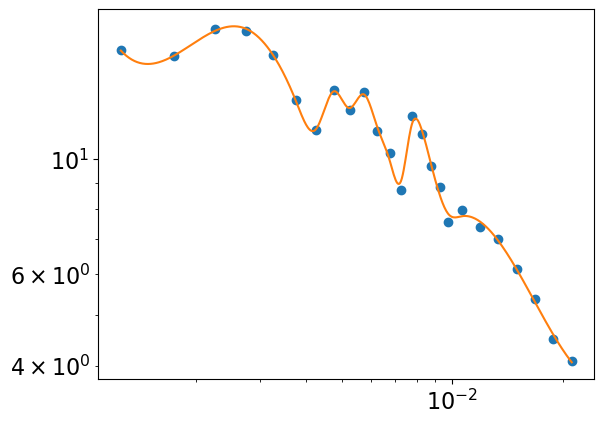

In [298]:
k_smooth, Pk_smooth = smooth_power_spectrum_loglog(subset['kc'], subset['Pk'], s_factor=0.01)

k_fit, P_fit, *popt_mock = fit_PD13Lorentz_from_power(k_smooth, Pk_smooth, 2.8)

plt.loglog(subset['kc'], subset['Pk'], 'o')
plt.loglog(k_fit,P_fit)

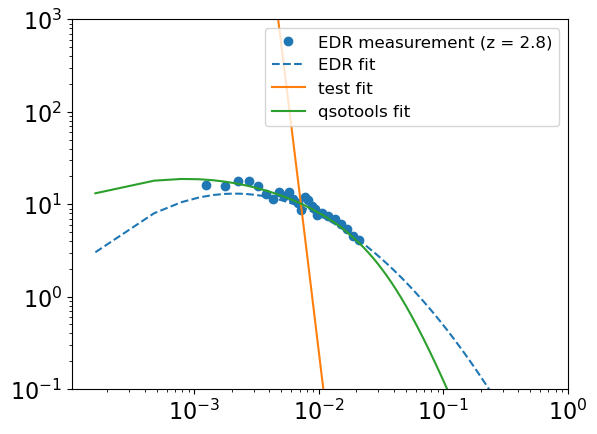

In [299]:
qsotools_params = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)


test_fit = evaluatePD13Lorentz((bin_centers, target_redshift),
                               *popt_mock)
qsotools_fit = evaluatePD13Lorentz((bin_centers, target_redshift),
                               *qsotools_params)
desi_edr_fit = evaluatePD13Lorentz((bin_centers, target_redshift),
                               *DESI_EDR_PARAMETERS)

plt.loglog(subset['kc'], subset['Pk'], 'o', label='EDR measurement (z = 2.8)')
plt.loglog(bin_centers, desi_edr_fit, label='EDR fit', color='tab:blue', ls='--')
plt.loglog(bin_centers, test_fit, label='test fit')
plt.loglog(bin_centers, qsotools_fit, label='qsotools fit')
plt.xlim(xmax=10e-1)
plt.ylim(ymin=10e-2, ymax = 10e2)
plt.legend(loc='upper right', fontsize=12)

In [300]:
popt_mock

[0.040765297958641096,
 -0.637087702361425,
 -0.293111820430063,
 10.12171629281311,
 43.79326126679762,
 -656.23475205565]

In [738]:
# # v_fit_fine, xi_g_fit_fine

# #####################################################################

# # xi_g_power = np.fft.rfft(xi_g_fit_fine) # / (2 * np.pi)
# xi_g_power = np.fft.rfft(xi_g_fit_fine) * 1.5
# g_fit_k_arr = 2 * np.pi * np.fft.rfftfreq(len(xi_g_fit_fine), d=fit_xig_dv)

# # w_g_fit_k = (g_fit_k_arr > 1e-4) & (g_fit_k_arr < 0.05)  # Window for g_fit_k_arr

# #####################################################################

# min_slice = 200
# max_slice = 100000

# plt.loglog(g_fit_k_arr, xi_g_power, label = 'xi_g best fit, N = '+str(xi_g_power.size), color='tab:orange',  ls='--')
# plt.loglog(g_fit_k_arr[min_slice:max_slice], xi_g_power[min_slice:max_slice], label = 'xi_g best fit sliced', color='tab:blue',  ls='-')


# # plt.ylim([0.1, 1])
# plt.ylabel(r'$P_{G}(k)$')
# plt.xlabel('k (s/km)')
# plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
# plt.xlim(10e-6, 10e-2)

# plt.legend(fontsize=12, loc='lower left')

### Load from txt file

In [70]:

# Load the data, skipping comment lines (starting with '#')
data = np.loadtxt("/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test2-8_xiG_half_output.txt")  
# Extract velocity and xiG values into separate arrays
file_v = data[:, 0]         # First column
file_xiG = data[:, 1]       # Second column

# Print to check
# print("Velocity:", file_v)
# print("Xi_G:", file_xiG)



def truncate_trailing_zeros(x, y):
    # Find the last index where y is nonzero
    last_nonzero_index = np.max(np.nonzero(y))  
    
    # Ensure at least one zero remains at the end
    if last_nonzero_index < len(y) - 1 and y[last_nonzero_index + 1] == 0:
        last_nonzero_index += 1  # Keep the first zero after the last nonzero value
    
    return x[:last_nonzero_index + 1], y[:last_nonzero_index + 1]

   
v_truncated, xiG_truncated = truncate_trailing_zeros(file_v, file_xiG)


Oversampled velocity shape: (1048576,)
Oversampled xig shape: (1048576,)


NameError: name 'full_v' is not defined

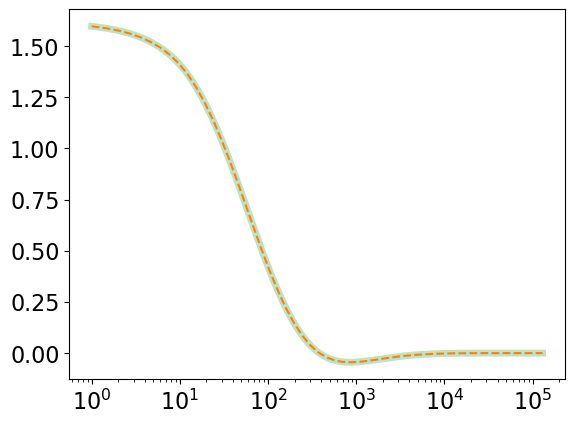

In [71]:
# Step 1: Generate the original (fine) velocity array (2^20 points)
file_v_fine = np.linspace(v_truncated.min(), v_truncated.max(), 2**20)  # Linearly spaced

# Step 2: Interpolate xig onto the fine velocity grid
cs = CubicSpline(v_truncated, xiG_truncated)  # Create cubic spline interpolator
file_xi_g_fine = cs(file_v_fine)  # Evaluate at fine velocity points

# Output: xig_fine and v_fine now contain 2^20 points
print("Oversampled velocity shape:", file_v_fine.shape)  # Should be (2^20,)
print("Oversampled xig shape:", file_xi_g_fine.shape)  # Should be (2^20,)

plt.semilogx(file_v_fine, file_xi_g_fine, label='re-interpolated, N = '+str(file_xi_g_fine.size), color='tab:green', lw=5, alpha=0.3)
plt.semilogx(v_truncated, xiG_truncated, label=r"$\xi_G$ file, N = "+str(file_xiG.size), color="tab:orange", ls='--')
plt.semilogx(full_v, full_xiG, label=f'full cf, N = {full_v.size}', color='tab:blue', ls='dotted', alpha=0.7)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.legend(fontsize=14)
# plt.title(r"$\xi_F$ Residual (EDR - Fit)")

In [72]:
dv_fit_fine = np.diff(file_v_fine)  # Compute velocity spacing

# Check if the spacing is constant
print("Min spacing:", np.min(dv_fit_fine))
print("Max spacing:", np.max(dv_fit_fine))
print("Mean spacing:", np.mean(dv_fit_fine))

file_xig_fine_dv = np.mean(dv_fit_fine)

# If the min and max values differ significantly, the grid is not uniform
if np.allclose(np.min(dv_fit_fine), np.max(dv_fit_fine), rtol=1e-6):
    print("Velocity grid is evenly spaced ✅")
else:
    print("Velocity grid is NOT evenly spaced ❌")


Min spacing: 0.12363045656820759
Max spacing: 0.12363045658275951
Mean spacing: 0.1236304565720144
Velocity grid is evenly spaced ✅


dv: 0.12363045657201432


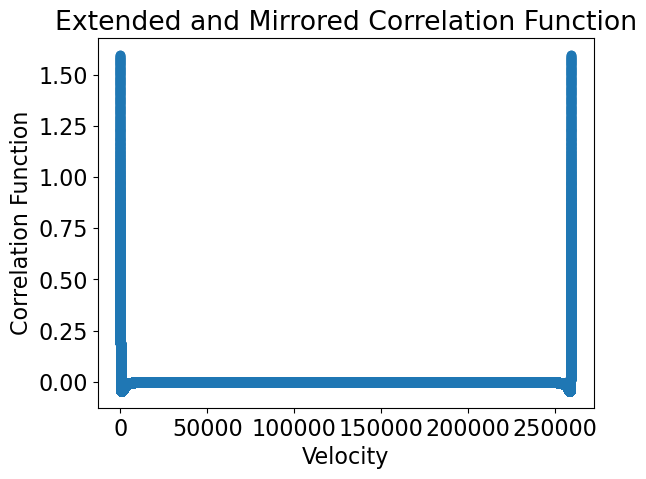

In [73]:
# Extend the velocity array
v_spacing = file_v_fine[1] - file_v_fine[0]  # Compute the step size
print(f'dv: {v_spacing}')
v_extended = np.concatenate([file_v_fine, file_v_fine + file_v_fine[-1] + v_spacing])

# Mirror the correlation function values
file_xig_extended = np.concatenate([file_xi_g_fine, file_xi_g_fine[::-1]])

# Plot the result
plt.plot(v_extended, file_xig_extended, marker='o', linestyle='-')
plt.xlabel("Velocity")
plt.ylabel("Correlation Function")
plt.title("Extended and Mirrored Correlation Function")
plt.show()

#### open cf file, export p_G file

In [75]:
safe_z = '2-8'

full_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/CF/test{safe_z}_xiG_full_output.txt'

# Load the data, skipping comment lines (starting with '#')
data2 = np.loadtxt(full_path)  
# Extract velocity and xiG values into separate arrays
full_v = data2[:, 0]         # First column
full_xiG = data2[:, 1]       # Second column

# Print to check
full_v_spacing = full_v[1] - full_v[0]
full_v_spacing

0.9999990000000001

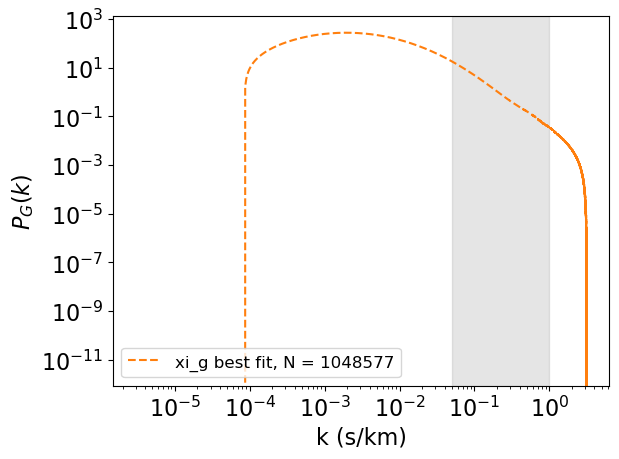

In [76]:

#####################################################################

file_xig_power = np.fft.rfft(full_xiG) * full_v_spacing # mult. by dv
file_xig_karr = 2 * np.pi * np.fft.rfftfreq(len(full_xiG/2), d=full_v_spacing)

# w_g_fit_k = (g_fit_k_arr > 1e-4) & (g_fit_k_arr < 0.05)  # Window for g_fit_k_arr


min_slice = 200
max_slice = 200000

sliced_power = file_xig_power[min_slice:max_slice]
sliced_karr = file_xig_karr[min_slice:max_slice]

#####################################################################

plt.loglog(file_xig_karr, file_xig_power, label = 'xi_g best fit, N = '+str(file_xig_power.size), color='tab:orange',  ls='--')

plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
# plt.xlim(10e-6, 10e-2)
plt.legend(fontsize=12, loc='lower left')

In [77]:
# # export / save P_G
# export_filename = f'P_G-{safe_z}_new.txt'
# # Stack and save the arrays as two columns: k and P(k)
# np.savetxt(export_filename, np.column_stack((file_xig_karr, file_xig_power.real)), 
#            header='k [km/s]^-1    P(k)', fmt='%.6e')
# print("Data exported successfully!")


In [78]:
w_g_fit_k = (file_xig_karr > 1e-4) & (file_xig_karr < 0.05)  # Window for g_fit_k_arr

sliced_power = file_xig_power[w_g_fit_k]
sliced_karr = file_xig_karr[w_g_fit_k]

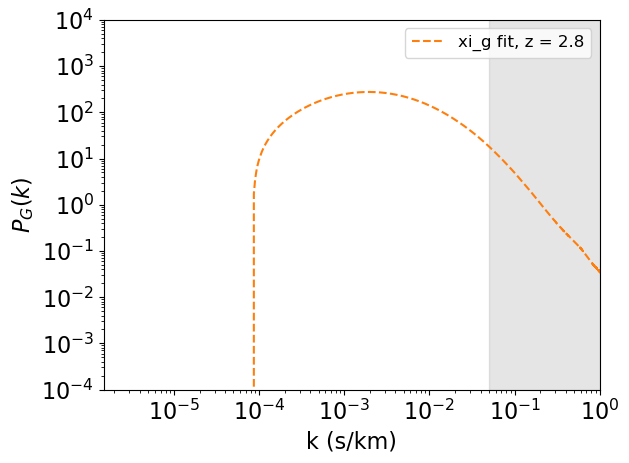

In [80]:
kmodes = (np.fft.rfftfreq(n=file_xig_power.size, d=1) * 2 * np.pi) + 1e-12 # factor of 2pi
def power_spectrum(k, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8):  #kmodes 
    pk = ( (k / k0)**(n - alpha * np.log(k / k0)) ) / (1 + (k / k1)**gamma)
    pk_i = np.arange(len(pk))
    
    mask = np.isfinite(pk)
    pk_filtered=np.interp(pk_i, pk_i[mask], pk[mask])
    return(pk_filtered)

plt.loglog(file_xig_karr, file_xig_power, label = 'xi_g fit, z = 2.8', color='tab:orange',  ls='--')
# plt.loglog(sliced_karr, sliced_power, label = 'xi_g best fit sliced', color='tab:blue',  ls='-')
# plt.loglog(kmodes[1:],power_spectrum(kmodes)[1:], label='Previous method')


plt.ylim([10e-5, 10000])
plt.xlim(None, 1)
plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
# plt.xlim(10e-6, 10e-2)
plt.legend(fontsize=12, loc='upper right')

## compute power from xi_F

/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


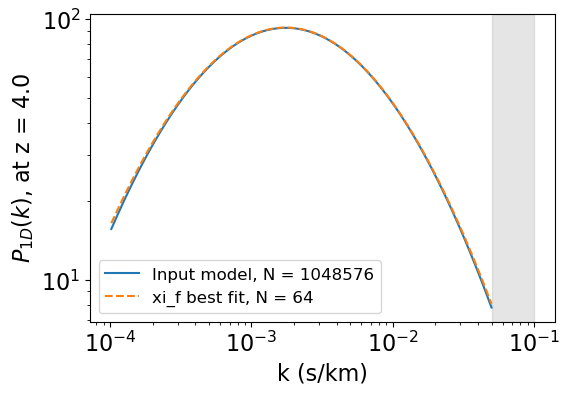

In [566]:

fit_power = np.fft.rfft(xif_fine) * new_dv * 2
fit_k_arr = 2 * np.pi * np.fft.rfftfreq(len(xif_fine), d=new_dv)

#########################################################################

p1d_precision = 1e-1
w_k = (k_arr > 1e-4) & (k_arr < 0.05)  # Window for k_arr
w_fit_k = (fit_k_arr > 1e-4) & (fit_k_arr < 0.05)  # Window for fit_k_arr
w_k_fine = (k_array_fine > 1e-4) & (k_array_fine < 0.05)  # Window for k_array_fine
ptrue = p1d_edr_fit[:, w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

#########################################################################

plt.figure(figsize=(6, 4))

# plt.errorbar(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], e_p1d[redshift_index], 
#              alpha=0.005, color='tab:blue')

plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
           label=r'Input model, N = '+str(numvpoints))

# plt.loglog(k_array_fine[w_k_fine], p1d_fine[w_k_fine], 
#            label='interpolated / target, z='+str(zlist[redshift_index])+
#            ', N='+str(new_size), color='tab:green', lw=3, alpha=0.7)

plt.loglog(fit_k_arr[w_fit_k], fit_power[w_fit_k], 
           label = 'xi_f best fit, N = '+str(downsample_size), color='tab:orange', ls='--')


# plt.xlim([10**-4, fit_k_arr.max()])
# plt.ylim([0.1, 100])
plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.ylabel(r'$P_{1D}(k)$, at z = '+str(zlist[redshift_index]))
plt.xlabel('k (s/km)')
plt.legend(fontsize=12, loc='lower left')


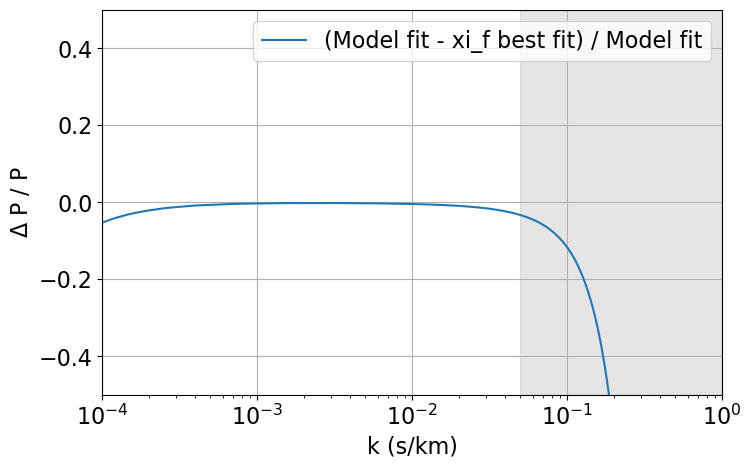

In [568]:

# Interpolate fit_power to match k_array
fit_power_interp = np.interp(k_arr, fit_k_arr, fit_power)

# Compute residual
delta_P = (p1d_edr_fit[redshift_index] - fit_power_interp) / p1d_edr_fit[redshift_index]

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, delta_P, label = "(Model fit - xi_f best fit) / Model fit")
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-1])
plt.ylim(-0.5,0.5)
plt.xlabel('k (s/km)')
plt.ylabel(r"$\Delta$ P / P")
plt.legend()
plt.grid()
plt.show()


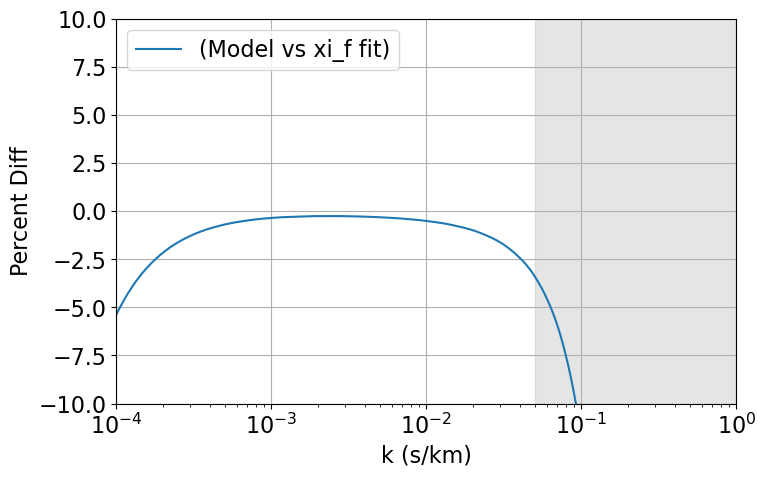

In [569]:

# Interpolate fit_power to match k_array
fit_power_interp = np.interp(k_arr, fit_k_arr, fit_power)

# Compute residual
percent_diff = 100 * ((p1d_edr_fit[redshift_index] - fit_power_interp) / p1d_edr_fit[redshift_index])

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, percent_diff, label = "(Model vs xi_f fit)")
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-1])
plt.ylim(-10,10)
plt.xlabel('k (s/km)')
plt.ylabel("Percent Diff")
plt.legend()
plt.grid()
plt.show()


#### Try mirroring xi_f and then getting power:

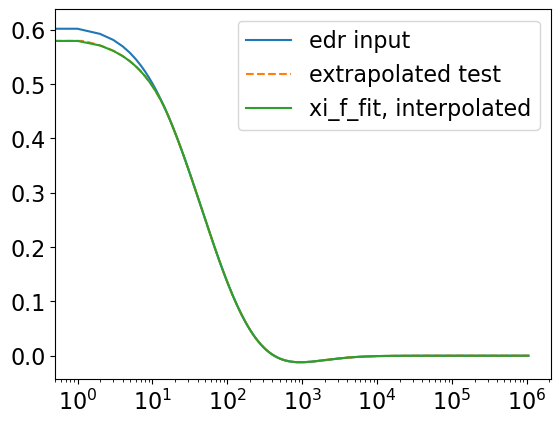

In [570]:
plt.semilogx(v_array, xif_edr_fit[redshift_index], label='edr input')
plt.semilogx(v_extrapolated, xi_f_optimized_extrapolated, label='extrapolated test', ls='--')
plt.semilogx(v_fine, xif_fine, label='xi_f_fit, interpolated')
plt.legend()

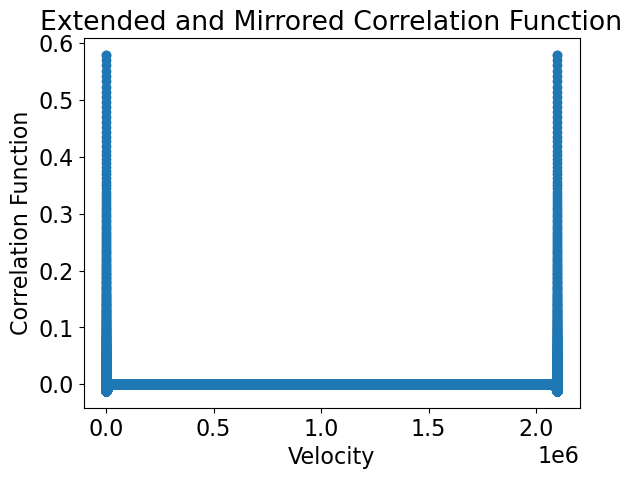

In [571]:
# Extend the velocity array
v_spacing = v_fine[1] - v_fine[0]  # Compute the step size
v_extended = np.concatenate([v_fine, v_fine + v_fine[-1] + v_spacing])

# Mirror the correlation function values
xi_f_extended = np.concatenate([xif_fine, xif_fine[::-1]])

# Plot the result
plt.plot(v_extended, xi_f_extended, marker='o', linestyle='-')
plt.xlabel("Velocity")
plt.ylabel("Correlation Function")
plt.title("Extended and Mirrored Correlation Function")
plt.show()

In [572]:

test_fit_power = np.fft.rfft(xi_f_extended) * v_spacing # mult. by dv
test_fit_k_arr = 2 * np.pi * np.fft.rfftfreq(len(xi_f_extended/2), d=v_spacing)

#########################################################################

p1d_precision = 1e-1

w_k = (k_arr > 1e-4) & (k_arr < 0.1)  # Window for k_arr
w_fit_k = (test_fit_k_arr > 1e-4) & (test_fit_k_arr < 0.1)  # Window for fit_k_arr
w_k_fine = (k_array_fine > 1e-4) & (k_array_fine < 0.1)  # Window for k_array_fine

ptrue = p1d_edr_fit[:, w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

#########################################################################


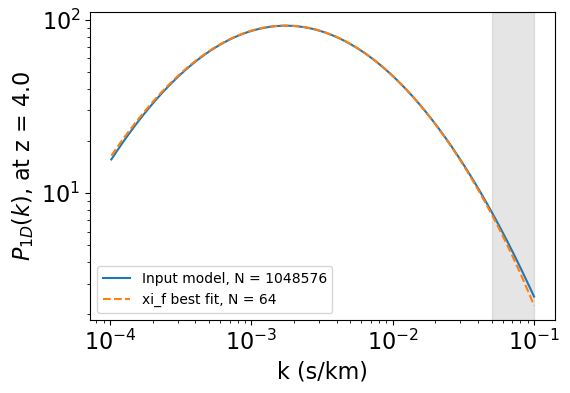

In [573]:

plt.figure(figsize=(6, 4))

# Extract data using your index mask (w_k)
temp_k = k_arr[w_k]
temp_p = p1d_edr_fit[redshift_index, w_k]
temp_e = np.full_like(temp_k, e_p1d[redshift_index])

# Normalize k_values on a log scale, then map alpha to a smooth range
log_k_values = np.log10(temp_k)  # Take log of k-values
log_k_min = np.min(log_k_values)
log_k_max = np.max(log_k_values)

# Set alpha values to decrease logarithmically: higher alpha for lower k (log(k)) values
# alpha_values = 0.05 + (1 - 0.2) * (log_k_max - log_k_values) / (log_k_max - log_k_min)
# alpha_values = 0.05 + (1 - 0.05) * (1 - (temp_k - np.min(temp_k)) / (np.max(temp_k) - np.min(temp_k)))

# # Loop over each point to plot errorbars with its specific alpha
# for k_val, p_val, err, alpha_val in zip(temp_k, temp_p, temp_e, alpha_values):
#     plt.errorbar(k_val, p_val, yerr=err, color='tab:blue', alpha=alpha_val)

plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
           label=r'Input model, N = ' + str(numvpoints))

# plt.loglog(k_array_fine[w_k_fine], p1d_fine[w_k_fine], 
#            label='interpolated / target, z=' + str(zlist[redshift_index]) +
#            ', N=' + str(new_size), color='tab:green', lw=3, alpha=0.7)

plt.loglog(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
           label='xi_f best fit, N = ' + str(downsample_size), color='tab:orange', ls='--')

plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.ylabel(r'$P_{1D}(k)$, at z = ' + str(zlist[redshift_index]))
plt.xlabel('k (s/km)')
plt.legend(fontsize=10, loc='lower left')

plt.show()


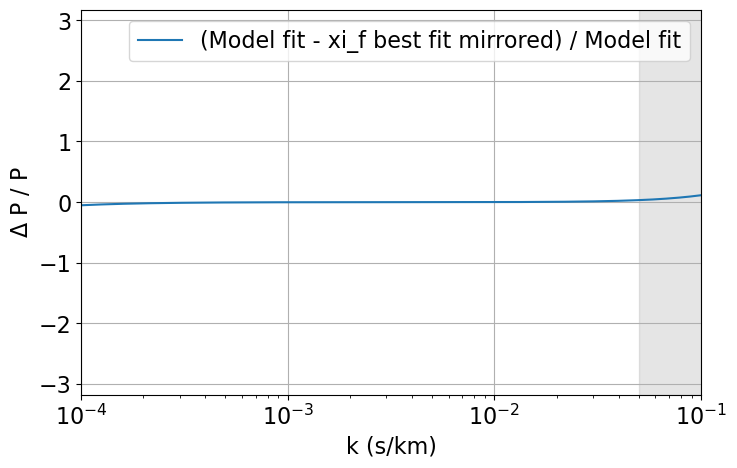

In [574]:

# Interpolate fit_power to match k_array
fit_power_interp_2 = np.interp(k_arr, test_fit_k_arr, test_fit_power)

# Compute residual
delta_P = np.real((p1d_edr_fit[redshift_index] - fit_power_interp_2) / p1d_edr_fit[redshift_index])

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, delta_P, label = "(Model fit - xi_f best fit mirrored) / Model fit")
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-2])
plt.ylim(-delta_P.max(),delta_P.max())
plt.xlabel('k (s/km)')
plt.ylabel(r"$\Delta$ P / P")
plt.legend()
plt.grid()
plt.show()


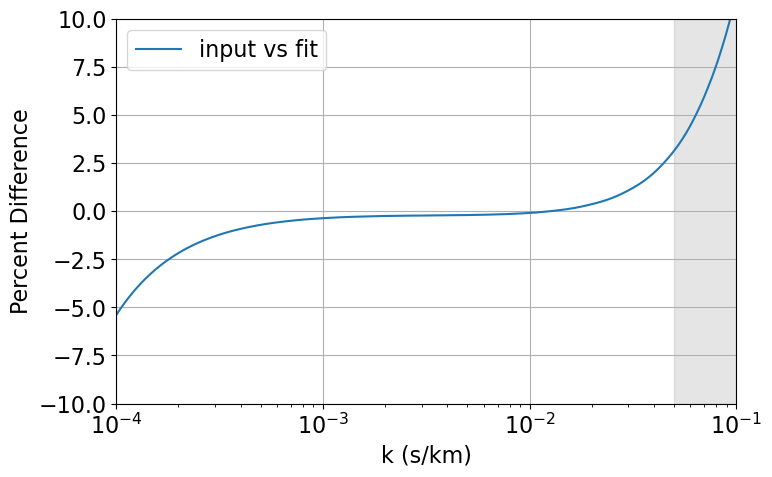

In [575]:

# Compute residual
percent_diff = 100 * np.real((p1d_edr_fit[redshift_index] - fit_power_interp_2) / p1d_edr_fit[redshift_index]) 

# Plot residual
plt.figure(figsize=(8, 5))
plt.semilogx(k_arr, percent_diff, label='input vs fit')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.xlim([10e-5,10e-2])
plt.ylim(-10,10)
plt.xlabel('k (s/km)')
plt.ylabel("Percent Difference")
plt.legend(loc='upper left')
plt.grid()
plt.show()


### compare to lyspeq output

In [106]:
import os
import sys
import datetime
import numpy as np
from glob import glob
from astropy.table import Table, QTable
from astropy.time import Time
from astropy.io import ascii, fits
from astropy import table 
import scipy.optimize
#import ephem
import time

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#### fujilupe mocks

In [72]:
rawdir1 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/lyspeq/output_lyspeq/tests/results/picca-true/'
file1 = rawdir1 + 'fujilupe-mock-1.5-4-sm20-o3-true-ch2-loglam2-nfo_it1_quadratic_power_estimate_detailed.txt'

In [73]:
data1 = ascii.read(file1)
data1 # PICCA DATA

z,k1,k2,kc,Pfid,ThetaP,Pest,ErrorP,d,b,t
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.0,0.0,0.0005,0.00025,3.996125,0.411806,4.407931,0.6082942,8.146866,3.360684,4.374376
2.0,0.0005,0.001,0.00075,7.558553,-0.1083307,7.450223,0.1505656,12.067,4.666906,7.508421
2.0,0.001,0.0015,0.00125,9.212059,0.01140944,9.223469,0.1399706,14.83425,5.655576,9.167269
2.0,0.0015,0.002,0.00175,9.940814,-0.03862794,9.902186,0.1435882,15.69783,5.89341,9.843051
2.0,0.002,0.0025,0.00225,10.20364,-0.1060359,10.0976,0.1452992,15.96837,5.983198,10.09121
2.0,0.0025,0.003,0.00275,10.21612,-0.1488498,10.06727,0.1452249,15.9452,5.99649,10.09756
2.0,0.003,0.0035,0.00325,10.08865,0.05901802,10.14767,0.144025,16.01243,5.984535,9.968877
2.0,0.0035,0.004,0.00375,9.881701,-0.002627657,9.879073,0.1422319,15.68994,5.929267,9.763298
2.0,0.004,0.0045,0.00425,9.63009,-0.2208928,9.409197,0.1400843,15.16432,5.870241,9.514968


In [75]:
rawdir2 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/lyspeq/output_lyspeq/test_2_qsonic/results/picca-true/'
ext = 'fujilupe-mock-1.5-4-sm20-o3-true-ch2-loglam2-nfo_it1_quadratic_power_estimate_detailed.txt'
file2 = rawdir2 + ext
data2 = ascii.read(file2)
data2 # QSONIC DATA

z,k1,k2,kc,Pfid,ThetaP,Pest,ErrorP,d,b,t
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.0,0.0,0.0005,0.00025,3.996125,0.5010915,4.497217,0.6113295,8.28355,3.410648,4.37181
2.0,0.0005,0.001,0.00075,7.558553,-0.05378351,7.50477,0.1510605,12.11103,4.655627,7.509183
2.0,0.001,0.0015,0.00125,9.212059,0.0472185,9.259278,0.1406211,14.86193,5.645353,9.169361
2.0,0.0015,0.002,0.00175,9.940814,0.01572218,9.956536,0.1449393,15.74142,5.879739,9.845954
2.0,0.002,0.0025,0.00225,10.20364,-0.03542184,10.16822,0.1467104,16.02849,5.970316,10.0936
2.0,0.0025,0.003,0.00275,10.21612,-0.1276029,10.08852,0.1467472,15.95601,5.983288,10.10032
2.0,0.003,0.0035,0.00325,10.08865,0.1084467,10.1971,0.1455806,16.05448,5.974417,9.971619
2.0,0.0035,0.004,0.00375,9.881701,0.023112,9.904813,0.1437972,15.7079,5.918807,9.765976
2.0,0.004,0.0045,0.00425,9.63009,-0.1620622,9.468027,0.1416358,15.21501,5.85946,9.517613


<Figure size 640x480 with 0 Axes>

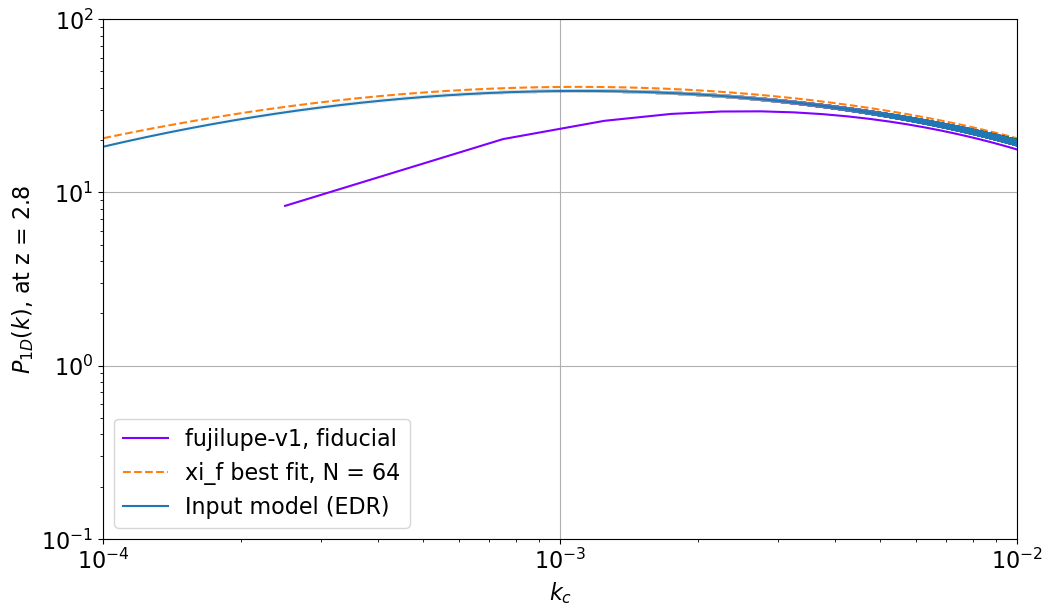

In [105]:

plt.figure()

NUM_COLORS = 10
cm = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8]:    
for i in [2.8]:    
    zmask2 = data2['z'] == i
    # plt.plot(data2['kc'][zmask2], np.multiply(data2['kc'][zmask2],data2['Pest'][zmask2])/np.pi, label = "fujilupe-v1, z = " + str(i)) 
    plt.plot(data2['kc'][zmask2], data2['Pfid'][zmask2], label = "fujilupe-v1, fiducial")

    plt.tight_layout()
    plt.xlabel("$k_c$")
    # plt.ylabel("$k_c$$P_{est}$ / $\pi$")
    plt.ylabel(r'$P_{1D}(k)$, at z = '+str(zlist[redshift_index]))
    plt.xscale("log")
    plt.yscale("log")
    plt.grid()
    # plt.title('fujilupe-v1.0/desi-1.5-4' )

    #plt.show()

    plt.loglog(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
               label = 'xi_f best fit, N = '+str(downsample_size), color='tab:orange', ls='--')

    plt.errorbar(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], e_p1d[redshift_index], 
                 alpha=0.005, color='tab:blue')
    
    plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
               label=r'Input model (EDR)')

    
    plt.xlim([10**-4, 10e-3])
    plt.ylim([0.1, 100])
    plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')

    plt.legend()


#### iron mocks and data

In [108]:
# DATA
rawdir1 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/iron_data_vs_mocks/lyspeq_ouput/data_bals_masked/tests/results/picca-true/'
file1 = rawdir1 + 'desi-iron-bal_mask-n2_it1_quadratic_power_estimate_detailed.txt'

data1 = ascii.read(file1)


# MOCK
rawdir2 = '/global/cfs/cdirs/desicollab/users/mherbold/tests/iron_data_vs_mocks/lyspeq_ouput/iron_mock/output/tests/results/picca-true/'
ext = 'desi-iron-bal_mask-n2_it1_quadratic_power_estimate_detailed.txt'
file2 = rawdir2 + ext

data2 = ascii.read(file2)

<Figure size 640x480 with 0 Axes>

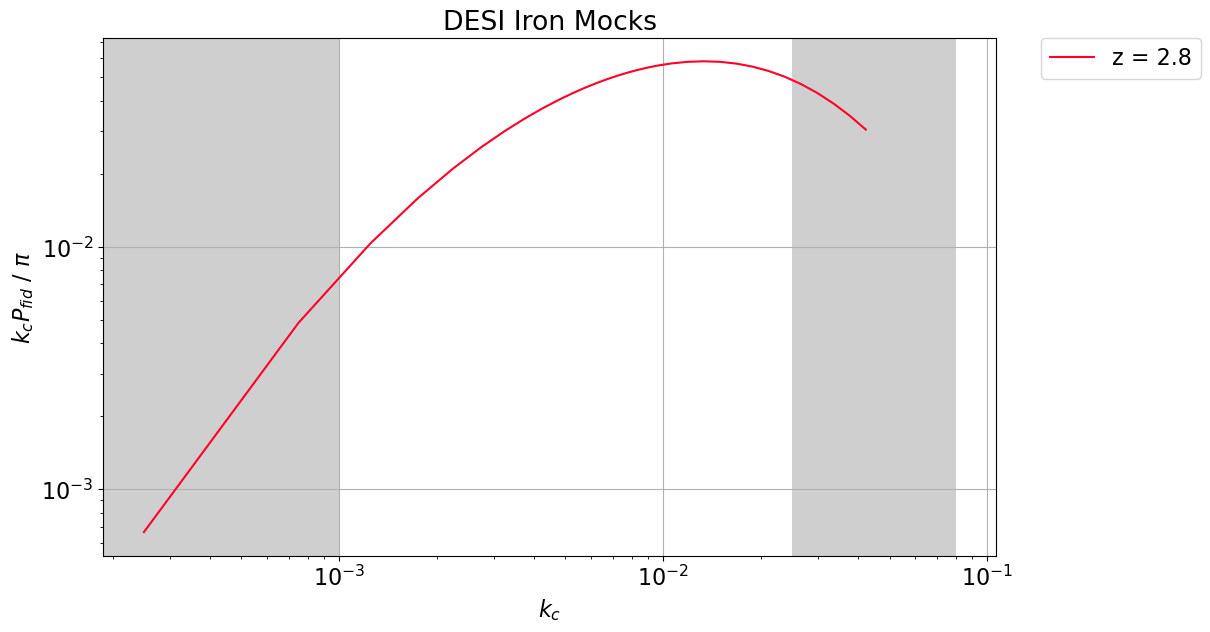

In [115]:
##########################################################################################################################
# USING MOCK ONLY for ALL redshifts
##########################################################################################################################

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]:    
for i in [2.8]:
    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], np.multiply(data2['kc'][zmask2],data2['Pfid'][zmask2])/np.pi, label = 'z = ' + str(i)) 

    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$k_c$$P_{fid}$ / $\pi$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Mocks' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    
    # plt.ylim([-1.5, 1.5])
    # plt.xlim([0.0005, 0.045])

    #plt.show()

##########################################################################################################################
##########################################################################################################################

/tmp/ipykernel_905909/3755152483.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([-1.5, 1.5])


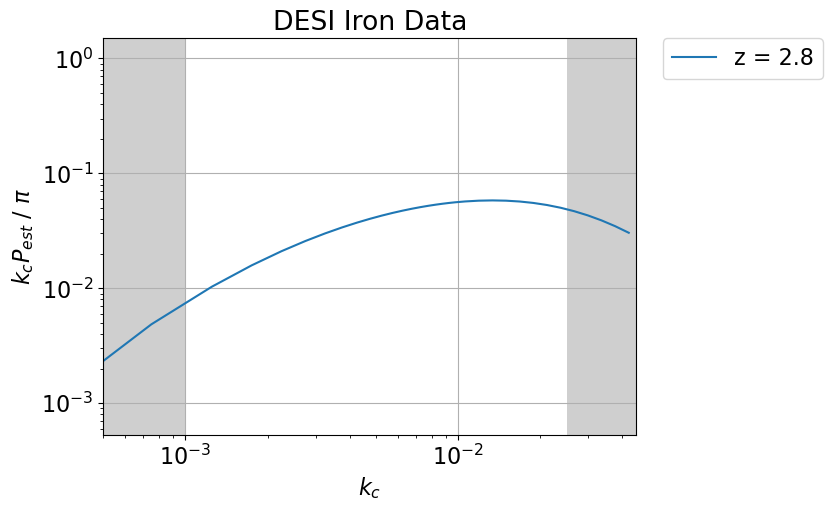

In [118]:
##########################################################################################################################
# USING Data ONLY for ALL redshifts
##########################################################################################################################

# for i in [2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2]:    
for i in [2.8]:
    zmask1 = data1['z'] == i
    plt.plot(data1['kc'][zmask1], np.multiply(data1['kc'][zmask1],data1['Pfid'][zmask1])/np.pi, label = 'z = ' + str(i)) 

    plt.tight_layout()
    plt.xlabel("$k_c$")
    plt.ylabel("$k_c$$P_{est}$ / $\pi$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.grid()
    plt.title('DESI Iron Data' )
    
    x1 = 0.025
    x2 = 0.08
    plt.axvspan(x1, x2, color='silver', alpha=0.75, lw=0)
    x3 = 0.000
    x4 = 0.001
    plt.axvspan(x3, x4, color='silver', alpha=0.75, lw=0)
    
    plt.ylim([-1.5, 1.5])
    plt.xlim([0.0005, 0.045])

    #plt.show()

##########################################################################################################################
##########################################################################################################################

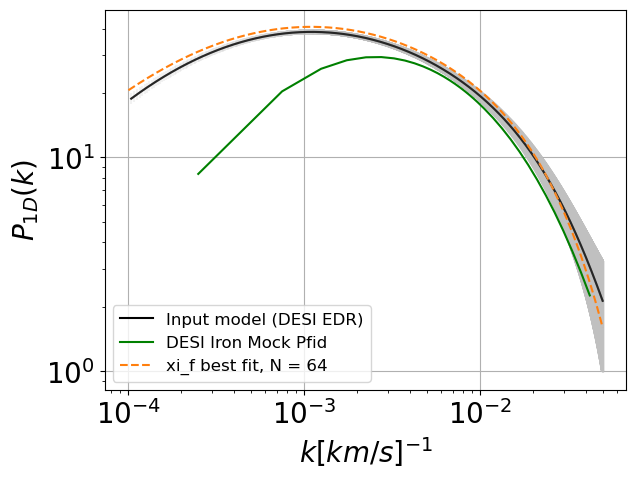

In [153]:
for i in [2.8]:    
    # zmask1 = data1['z'] == i
    # plt.plot(data1['kc'][zmask1], data1['Pfid'][zmask1], 
    #          label = 'DESI Iron Data Pfid', color = 'tab:red', ls='--') 

    plt.errorbar(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], e_p1d[redshift_index], 
                 alpha=0.2, color='silver')
    
    plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='black', 
               label=r'Input model (DESI EDR)')

    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], data2['Pfid'][zmask2], 
             label = 'DESI Iron Mock Pfid', color = 'green') 
    
    plt.loglog(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
               label = 'xi_f best fit, N = '+str(downsample_size), color='tab:orange', ls='--')

    plt.tight_layout()
    plt.xlabel("$k [km/s]^{-1}$")
    plt.ylabel("$P_{1D}(k)$")
    plt.xscale("log")
    plt.yscale("log")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.legend(loc='lower left', fontsize=12)
    plt.grid()
    
    # plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')


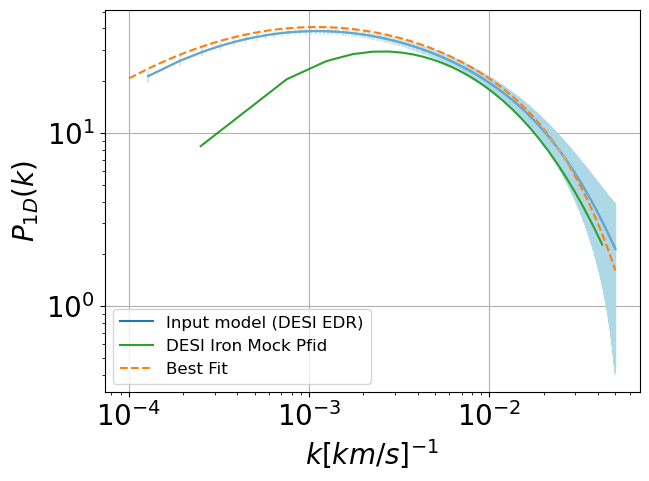

In [176]:
for i in [2.8]:    
    # zmask1 = data1['z'] == i
    # plt.plot(data1['kc'][zmask1], data1['Pfid'][zmask1], 
    #          label = 'DESI Iron Data Pfid', color = 'tab:red', ls='--') 

    plt.errorbar(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], e_p1d[redshift_index], 
                 alpha=0.5, color='lightblue')
    
    plt.plot(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], color='tab:blue', 
               label=r'Input model (DESI EDR)')

    zmask2 = data2['z'] == i
    plt.plot(data2['kc'][zmask2], data2['Pfid'][zmask2], 
             label = 'DESI Iron Mock Pfid', color = 'tab:green') 
    
    plt.plot(test_fit_k_arr[w_fit_k], test_fit_power[w_fit_k], 
               label = 'Best Fit', color='tab:orange', ls='--')

    plt.tight_layout()
    plt.xlabel("$k [km/s]^{-1}$")
    plt.ylabel("$P_{1D}(k)$")
    plt.xscale("log")
    plt.yscale("log")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.legend(loc='lower left', fontsize=12)
    # plt.legend(loc='upper right', fontsize=12)
    plt.grid()
    
    # plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
